# Crystal Sublimation
Crystal sublimation is modelled as a process in which every neighbour interaction has energy $-E$ and any atom not in the bulk of the crystal (ie without 6 neighbours) is able to sublime, using a sequential sampling method. The sphericity of the sphere is determined using Wadell sphericity on a convex hull fitted to the surface of the lattice (where possible) and as the ratio of surface to non surface atoms.

# Import Packages

In [3]:
import os
import glob
import numpy as np
from scipy.ndimage import convolve
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import imageio.v2 as imageio
plt.rcParams["figure.figsize"] = (20, 10)

# Functions

## For plotting

In [4]:
def points_plot(occ: np.ndarray,
              adj: np.ndarray,
              fname: str,
              title: str,
              size:int,
              dpi:int = 600
              ):
    """Plots array of points, colored by adjacency

    Parameters
    ----------
    occ : np.ndarray
        The occupancy matrix
    adj : np.ndarray
        The adjacency matrix
    fname : str
        The filename
    title : str
        The plot title
    size : int
        The 'size' of the lattice (determines plot dimensions)
    dpi : int, optional
        The dpi to save at, by default 600
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = occ.nonzero()
    ax.scatter(x, y, z, c=adj[x,y,z], alpha=1, vmax = 6, vmin = 3, cmap = 'plasma')
    ax.set_xlim(0, size-1)
    ax.set_ylim(0, size-1)
    ax.set_zlim(0, size-1)
    ax.set_box_aspect([1,1,1])
    # plt.show()
    plt.title(f'{title}')
    # plt.axis('off')
    plt.savefig(fname, dpi=dpi, bbox_inches = 'tight')
    plt.cla()
    plt.close()

In [5]:
def hull_plot(occ: np.ndarray,
              adj: np.ndarray,
              surf_sites: np.ndarray,
              hull: ConvexHull,
              fname: str,
              title: str,
              size:int,
              plot_points:bool = True
              ):
    """Plots array of points, colored by adjacency

    Parameters
    ----------
    occ : np.ndarray
        The occupancy matrix
    adj : np.ndarray
        The adjacency matrix
    surf_sites : np.ndarray
        The surface sites which the hull is fit to
    hull : ConvexHull
        The convex hull to plot
    fname : str
        The filename
    title : str
        The plot title
    size : int
        The 'size' of the lattice (determines plot dimensions)
    plot_points : bool, optional
        whether to plot individual points or just the hull, by default True
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if plot_points:
        x, y, z = occ.nonzero()
        ax.scatter(x, y, z, c=adj[x,y,z], alpha=1, vmax = 6, vmin = 3, cmap = 'plasma')
    ax.set_xlim(0, size-1)
    ax.set_ylim(0, size-1)
    ax.set_zlim(0, size-1)
    ax.set_box_aspect([1,1,1])
    for s in hull.simplices:
                s = np.append(s, s[0])  # Here we cycle back to the first coordinate
                ax.plot(surf_sites[s, 0], surf_sites[s, 1], surf_sites[s, 2], "r-")
    plt.title(f'{title}')
    # plt.axis('off')
    plt.savefig(fname, dpi=600, bbox_inches = 'tight')
    plt.cla()
    plt.close()

## For Simulation

In [6]:
def sublimation_sim(L:int = 8,
                    kT:float = 1.0,
                    seed:int = 0,
                    plot_hulls:bool = False,
                    plot_snap:bool = False,
                    plot_gif:bool = False,
                    ss_cycles: int = 5000,
                    ss_name: str = 'Snapshot',
                    gif_name: str = 'sublimation'
                    ):
    """Models the sublimation of a lattice using a sequential Monte Carlo-like method.
    Contains options for plotting snapshots and to produce a gif.
    Producing a gif substantially increases the runtime of the code

    Parameters
    ----------
    L : int, optional
        The side length of the cube lattice, by default 8
    kT : float, optional
        The value of kT used in the simulation, by default 1.0
    seed : int, optional
        The random seed, by default 0
    plot_hulls : bool, optional
        Whether to snapshot the convex hulls, by default False
    plot_snap : bool, optional
        Whether to snapshot the lattice arrangement, by default False
    plot_gif : bool, optional
        Whether to create a gif of the sublimation, by default False
    ss_cycles : int, optional
        How many steps to take between snapshots, by default 5000
    ss_name : str, optional
        The name of the snapshot files, by default 'Snapshot'
    gif_name : str, optional
        The name of the gif file, by default 'sublimation'

    Returns
    -------
    energies: np.ndarray
        The energy at each iteration
    size_atoms: np.ndarray
        The number of atoms at each iteration
    surface_size: np.ndarray
        The number of atoms on the surface at each iteration
    sphericity: np.ndarray
        The sphericity at each iteration
    """
    # set the random seed
    np.random.seed(seed)
    dimensions = (L, L, L)
    # Create the occupancy kernel saying which points are occupied
    # Everything is floating point as odd errors occured trying to use integers
    occ = np.ones(dimensions, 'float32')
    # The 3D kernel for convolution (to work out adjacency)
    kernel = np.array((((0,0,0),(0,1,0),(0,0,0)),
                   ((0,1,0),(1,0,1),(0,1,0)),
                   ((0,0,0),(0,1,0),(0,0,0))
                   ), 'float32')
    # The energy, number of atoms, number of atoms on the surface
    # and sphericity are tracked at each step
    energies = []
    size_atoms = []
    surface_size = []
    sphericity = []
    # counter to track cycles
    i = 0
    while True:
        # The number of atoms
        natoms = np.sum(occ)
        size_atoms.append(natoms)
        # Create the adjacency matrix as a convolution
        adj = convolve(occ, kernel, mode = 'constant') # mode is constant, as there are no interactions beyind the lattice
        # Keep only the sites where the is actually an atom
        adj = np.multiply(adj, occ)
        # Get those sites that are on the surface
        # surface atoms are those occupied points with less than 6 neighbours
        surface_atoms = np.where((adj<6) & (occ==1), 1 , 0)
        # get the coordinates of the surface sites
        surf_sites = np.argwhere((surface_atoms==1))
        # plotting
        if plot_gif:
            if i%50==0:
                points_plot(occ, adj, f"{i:05d}_gif.jpg", f"Iteration {i}", size = L, dpi = 70)
        if plot_snap:
            if i%ss_cycles==0:
                points_plot(occ, adj, f"{ss_name}_{i:05d}.jpg", f"Iteration {i}", size = L)
        # Try to calculate Wadell Sphericity (will fail if non convex)
        try:
            hull = ConvexHull(surf_sites) # a convex hull fit on the surface of the lattice
            # calculate Wadell sphericity
            V = hull.volume
            A = hull.area
            sph = (np.power(np.pi, 1/3)*np.power(6*V, 2/3))/A
            sphericity.append(sph)
            if plot_hulls:
                if i%ss_cycles==0:
                    hull_plot(occ, adj, surf_sites, hull, f"{ss_name}_Hull_{i:05d}.jpg", f"Iteration {i}", size = L ) #
        except: pass
        n_surface = np.sum(surface_atoms)
        surface_size.append(n_surface)
        energy = -np.sum(adj)/2 # total energy is half the sum of the adjacencies
        energies.append(energy)
        # iterate counter
        i += 1
        # simulation is complete when there are no atoms left to remove
        if natoms == 0:
            break
        # select a random removable site
        site = np.random.randint(len(surf_sites))
        # get the coordinates of that point
        pos = tuple(surf_sites[site])
        # get the number of atoms it is adjacent to
        borders = adj[pos]
        # get the probability of removal
        p_removal = np.exp(-borders/kT)
        # determine if the atom is removed
        if p_removal>np.random.rand():
            # remove the atom
            occ[pos] = 0
    # produce the gif if desired
    if plot_gif:
        # get all image files for the gif
        png_files = glob.glob('*_gif.*')
        # write the image file to the gif
        with imageio.get_writer(f'{gif_name}.gif', mode='I') as writer:
            for filename in png_files:
                image = imageio.imread(filename)
                writer.append_data(image)
                # delete the file
                os.remove(filename)
    return np.array(energies), np.array(size_atoms), np.array(surface_size), np.array(sphericity)


In [7]:
def sublimation_sim_checker(L:int = 8,
                    kT:float = 1.0,
                    seed:int = 0,
                    calc_sphericity:bool = False,
                    plot_hulls:bool = False,
                    plot_snap:bool = False,
                    plot_gif:bool = False,
                    ss_cycles: int = 5000,
                    ss_name: str = 'Snapshot',
                    gif_name: str = 'sublimation'
                    ):
    """Models the sublimation of a lattice using a checkerboard Monte Carlo-like method.
    Contains options for plotting snapshots and to produce a gif.
    Producing a gif substantially increases the runtime of the code

    Parameters
    ----------
    L : int, optional
        The side length of the cube lattice, by default 8
    kT : float, optional
        The value of kT used in the simulation, by default 1.0
    seed : int, optional
        The random seed, by default 0
    calc_hulls : bool, optional
        Whether to calculate convex hull for Wadell sphericity, by default False
    plot_hulls : bool, optional
        Whether to snapshot the convex hulls (ignored if calc_sphericity==False), by default False
    plot_snap : bool, optional
        Whether to snapshot the lattice arrangement, by default False
    plot_gif : bool, optional
        Whether to create a gif of the sublimation, by default False
    ss_cycles : int, optional
        How many steps to take between snapshots, by default 5000
    ss_name : str, optional
        The name of the snapshot files, by default 'Snapshot'
    gif_name : str, optional
        The name of the gif file, by default 'sublimation'

    Returns
    -------
    energies: np.ndarray
        The energy at each iteration
    size_atoms: np.ndarray
        The number of atoms at each iteration
    surface_size: np.ndarray
        The number of atoms on the surface at each iteration
    sphericity: np.ndarray
        The sphericity at each iteration
    """
    # set the random seed
    np.random.seed(seed)
    dimensions = (L, L, L)
    # Create the occupancy kernel saying which points are occupied
    # Everything is floating point as odd errors occured trying to use integers
    occ = np.ones(dimensions, 'float32')
    # The 3D kernel for convolution (to work out adjacency)
    kernel = np.array((((0,0,0),(0,1,0),(0,0,0)),
                   ((0,1,0),(1,0,1),(0,1,0)),
                   ((0,0,0),(0,1,0),(0,0,0))
                   ), 'float32')
    # The checkerboard array

    checkerboard = np.indices((L,L,L)).sum(axis=0) % 2
    # The energy, number of atoms, number of atoms on the surface
    # and sphericity are tracked at each step
    energies = []
    size_atoms = []
    surface_size = []
    sphericity = []
    # counter to track cycles
    i = 0
    while True:
        # The number of atoms
        natoms = np.sum(occ)
        size_atoms.append(natoms)
        # Create the adjacency matrix as a convolution
        adj = convolve(occ, kernel, mode = 'constant') # mode is constant, as there are no interactions beyind the lattice
        # Keep only the sites where the is actually an atom
        adj = np.multiply(adj, occ)
        # Get those sites that are on the surface
        # surface atoms are those occupied points with less than 6 neighbours
        surface_atoms = np.where((adj<6) & (occ==1), 1 , 0)
        # plotting
        if plot_gif:
            if i%50==0:
                points_plot(occ, adj, f"{i:05d}_gif.jpg", f"Iteration {i}", size = L, dpi = 70)
        if plot_snap:
            if i%ss_cycles==0:
                points_plot(occ, adj, f"{ss_name}_{i:05d}.jpg", f"Iteration {i}", size = L)
        # calculating sphericity
        # use a convex hull
        if calc_sphericity:
            # get the coordinates of the surface sites
            surf_sites = np.argwhere((surface_atoms==1))
            try:
                hull = ConvexHull(surf_sites) # a convex hull fit on the surface of the lattice
                # calculate Wadell sphericity
                V = hull.volume
                A = hull.area
                sph = (np.power(np.pi, 1/3)*np.power(6*V, 2/3))/A
                sphericity.append(sph)
                if plot_hulls:
                    if i%ss_cycles==0:
                        hull_plot(occ, adj, surf_sites, hull, f"{ss_name}_Hull_{i:05d}.jpg", f"Iteration {i}", size = L, plot_points=False) #
            except: pass
        # else use cubes of side length 1
        else:
            pass
            # if natoms>0:
            #     V = natoms
            #     # surface area is the sum of contributions from each site on the surface
            #     A = np.sum(np.where((surface_atoms == 1), 6-adj,0))
            #     sph = (np.power(np.pi, 1/3)*np.power(6*V, 2/3))/A
            #     sphericity.append(sph)
        n_surface = np.sum(surface_atoms)
        surface_size.append(n_surface)
        energy = -np.sum(adj)/2 # total energy is half the sum of the adjacencies
        energies.append(energy)
        i += 1
        # simulation is complete when there are no atoms left to remove
        if natoms == 0:
            break
        # calculate the probability of any of the 'white' surface atoms evaporating
        prob = np.where(surface_atoms==1, np.exp(-adj/kT), 0)
        prob =np.multiply(checkerboard, prob)
        # see which atoms evaporate
        rand_mat = np.random.rand(L,L,L)
        occ = np.where((rand_mat>prob) & (occ == 1), 1 , 0) # those sites which are occupied are those not removed (rand_mat>prob) and which were previously occupied

        # Repeate for the other color
        # Create the adjacency matrix as a convolution
        adj = convolve(occ, kernel, mode = 'constant') # mode is constant, as there are no interactions beyind the lattice
        # Keep only the sites where the is actually an atom
        adj = np.multiply(adj, occ)
        # Get those sites that are on the surface
        # surface atoms are those occupied points with less than 6 neighbours
        surface_atoms = np.where((adj<6) & (occ==1), 1 , 0)
        # calculate the probability of any of the 'black' surface atoms evaporating
        prob = np.where(surface_atoms==1, np.exp(-adj/kT), 0)
        prob =np.multiply(1-checkerboard, prob)
        # see which atoms evaporate
        rand_mat = np.random.rand(L,L,L)
        occ = np.where((rand_mat>=prob) & (occ == 1), 1 , 0)
    # produce the gif if desired
    if plot_gif:
        # get all image files for the gif
        png_files = glob.glob('*_gif.*')
        # write the image file to the gif
        with imageio.get_writer(f'{gif_name}.gif', mode='I') as writer:
            for filename in png_files:
                image = imageio.imread(filename)
                writer.append_data(image)
                # delete the file
                os.remove(filename)
    return np.array(energies), np.array(size_atoms), np.array(surface_size), np.array(sphericity)

# Checkerboard Sampling
Checkerboard sampling speeds up the evaporation to the point significantly, but considers more atoms at each step and so the $8\times 8\times 8$ cube almost instantly disappears

In [8]:
energies, size_atoms, surface_size, sphericity = sublimation_sim_checker(L=8, calc_sphericity=True, plot_hulls=True, plot_snap=False, ss_cycles=5, ss_name='Checker_8_')

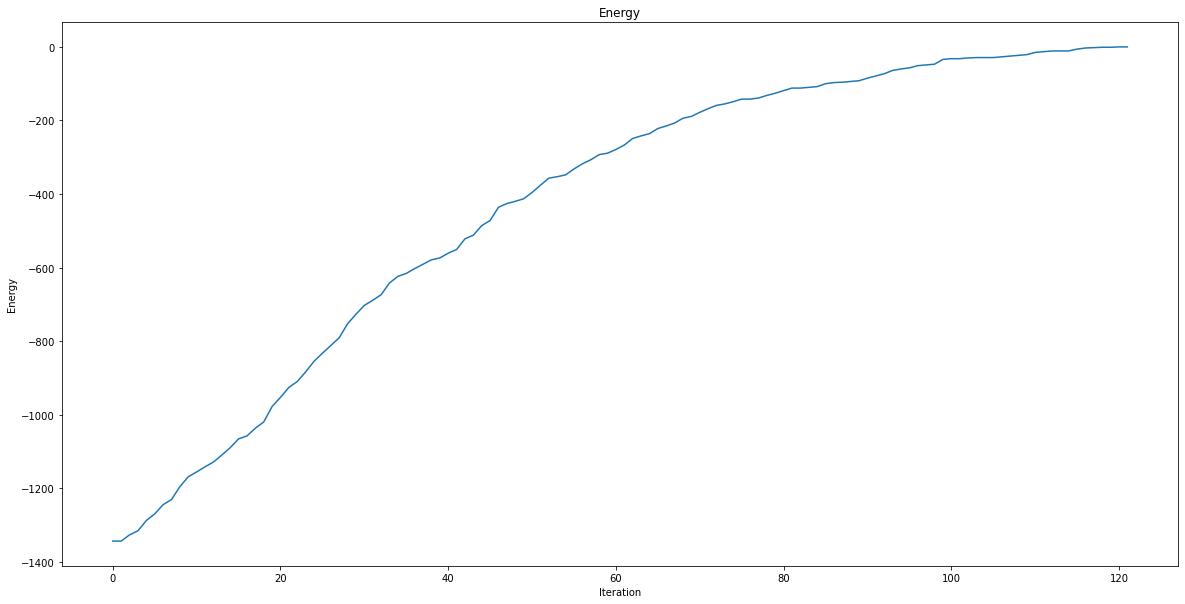

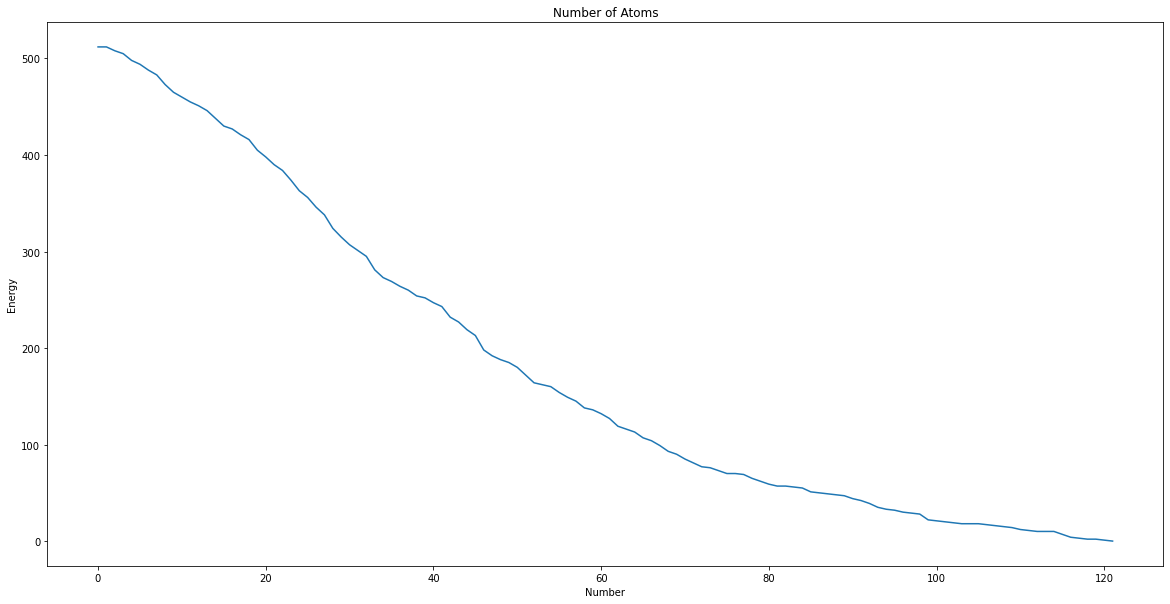

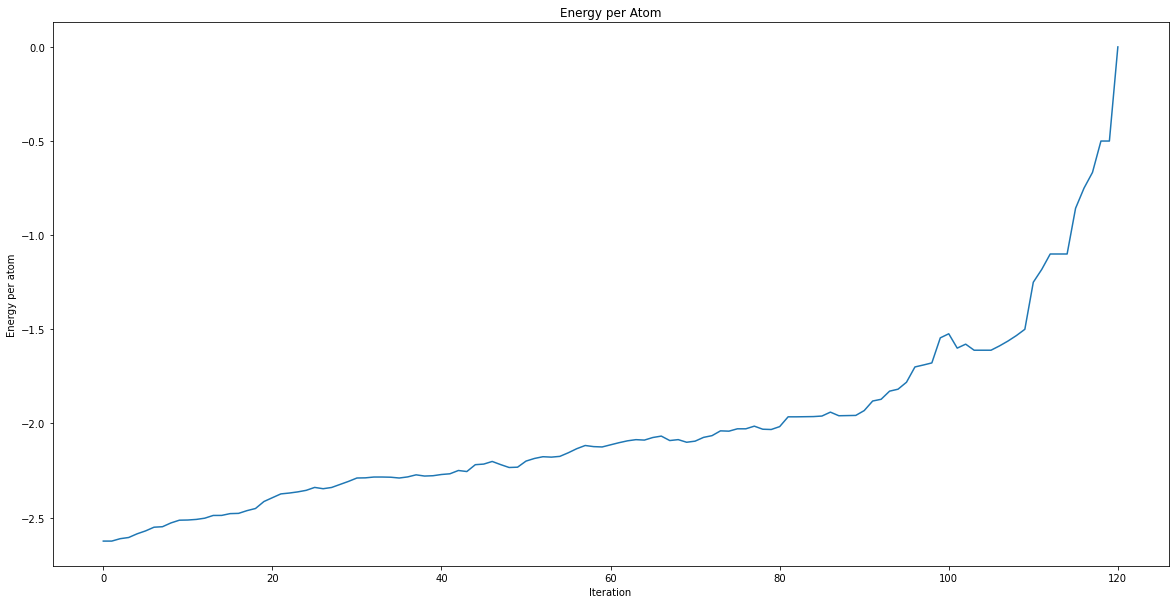

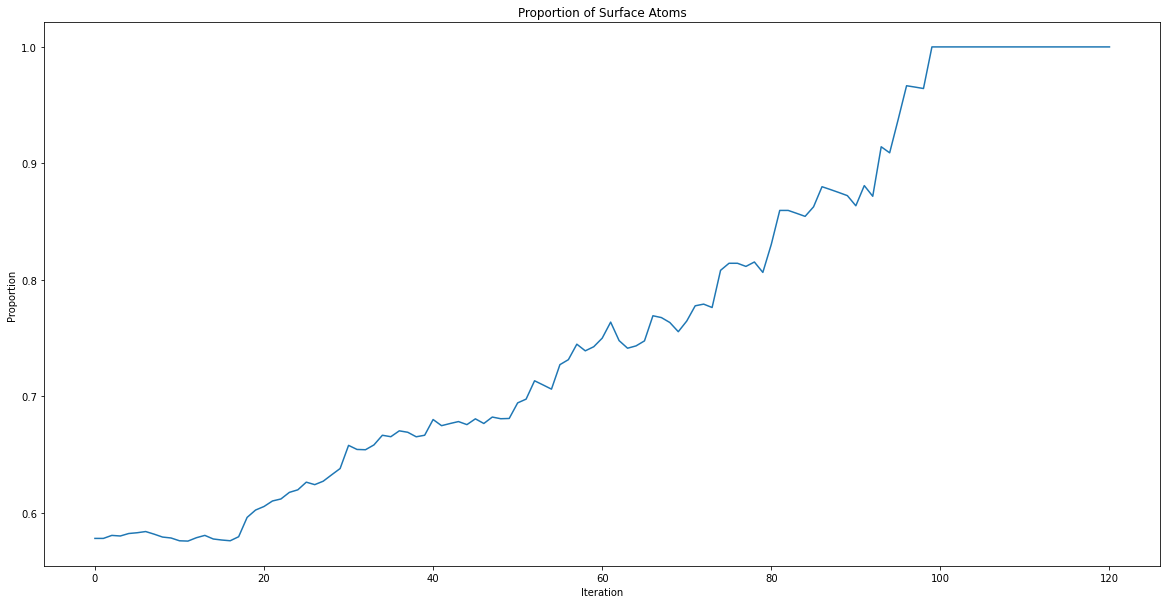

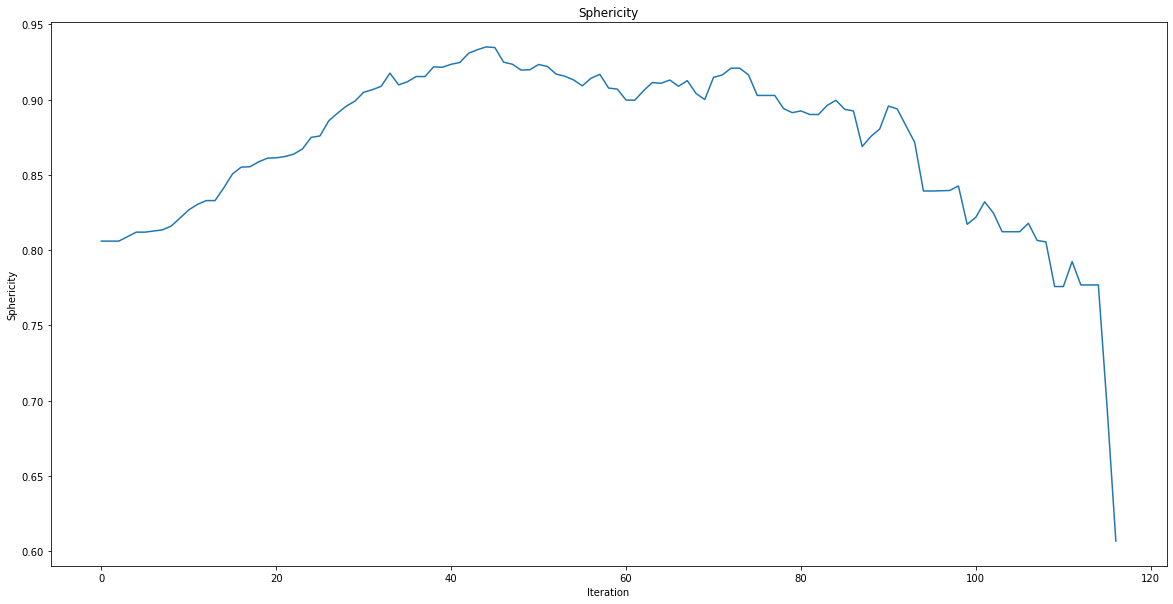

In [9]:
plt.plot(energies)
plt.title(f'Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()

plt.plot(size_atoms)
plt.title(f'Number of Atoms')
plt.xlabel('Number')
plt.ylabel('Energy')
plt.show()

plt.plot(energies[:-1]/size_atoms[:-1])
plt.title(f'Energy per Atom')
plt.xlabel('Iteration')
plt.ylabel('Energy per atom')
plt.show()

plt.plot(surface_size[:-1]/size_atoms[:-1])
plt.title(f'Proportion of Surface Atoms')
plt.xlabel('Iteration')
plt.ylabel('Proportion')
plt.show()

plt.plot(sphericity)
plt.title(f'Sphericity')
plt.xlabel('Iteration')
plt.ylabel('Sphericity')
plt.show()

## The speedup compared to sequential sampling

In [11]:
%%timeit -r 3 -n 50
energies, size_atoms, surface_size, sphericity = sublimation_sim_checker(L=8, calc_sphericity=True, plot_hulls=False, plot_snap=False, ss_cycles=5, ss_name='Checker_8_')

71.1 ms ± 480 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)


In [10]:
%%timeit -r 3 -n 50
energies, size_atoms, surface_size, sphericity = sublimation_sim(L=8,)

8.08 s ± 70.4 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


## The $128\times 128 \times 128$ lattice

In [45]:
energies, size_atoms, surface_size, sphericity = sublimation_sim_checker(L=128, calc_sphericity=True, plot_hulls=True, plot_snap=False, ss_cycles=100, ss_name='Checker')

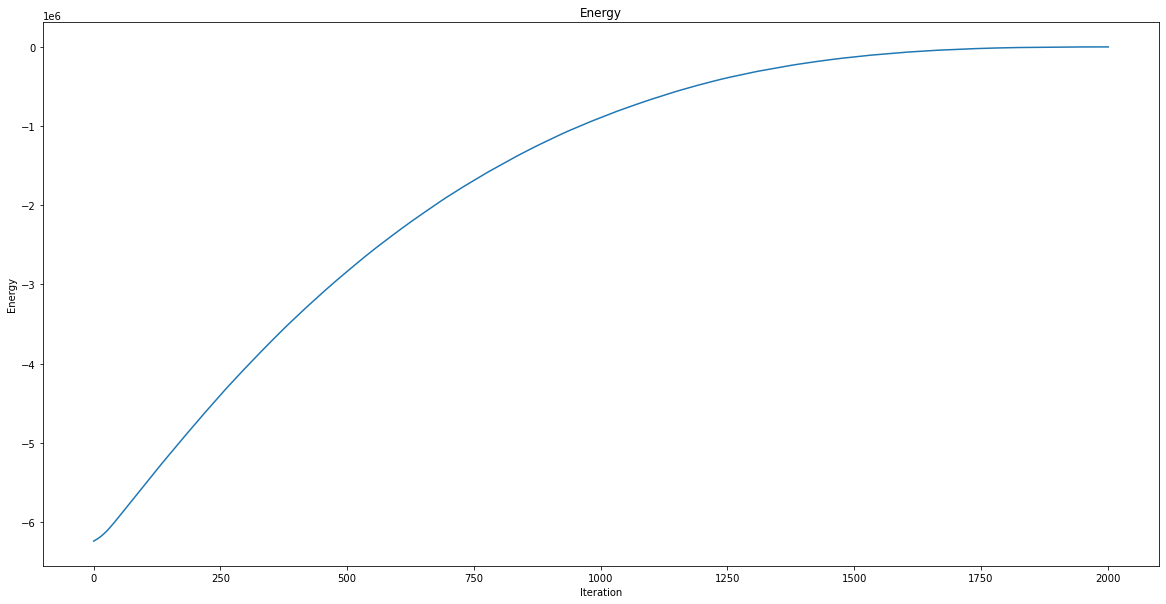

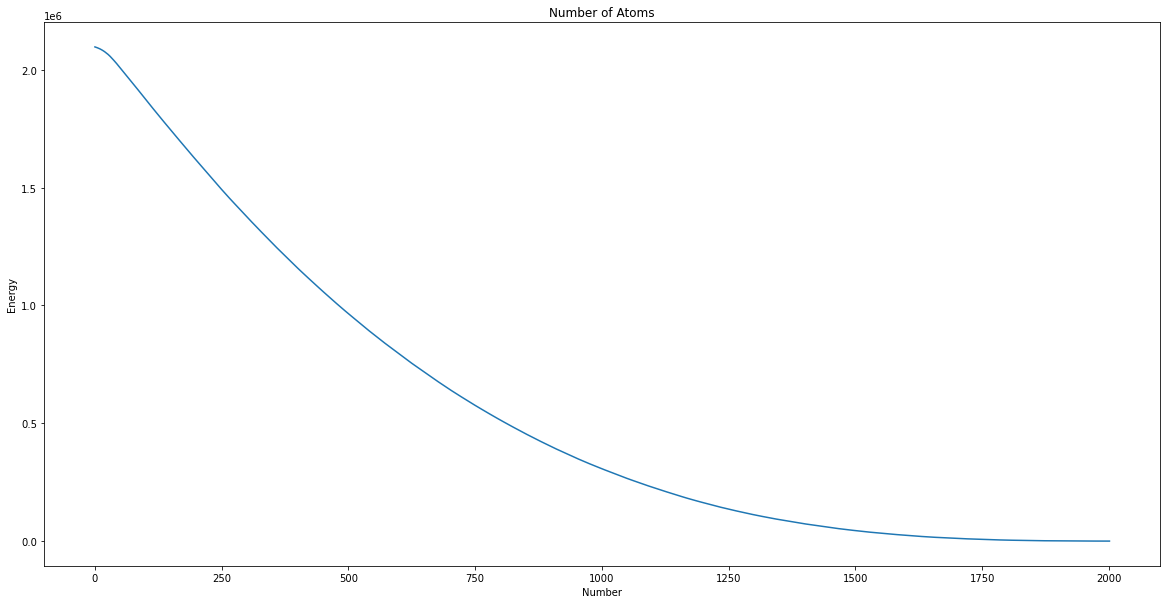

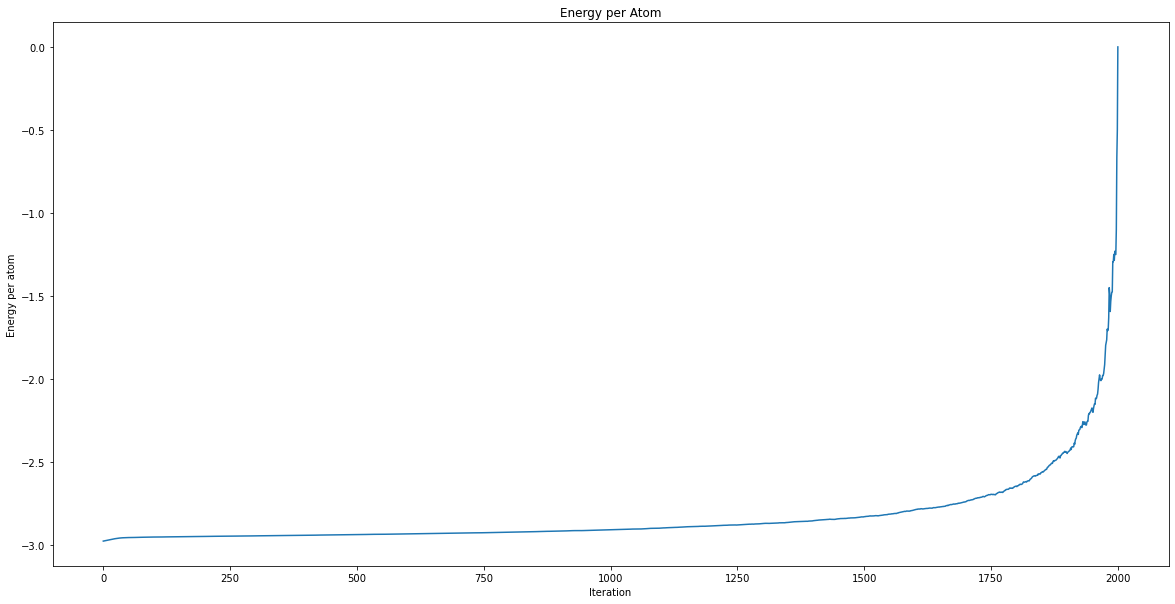

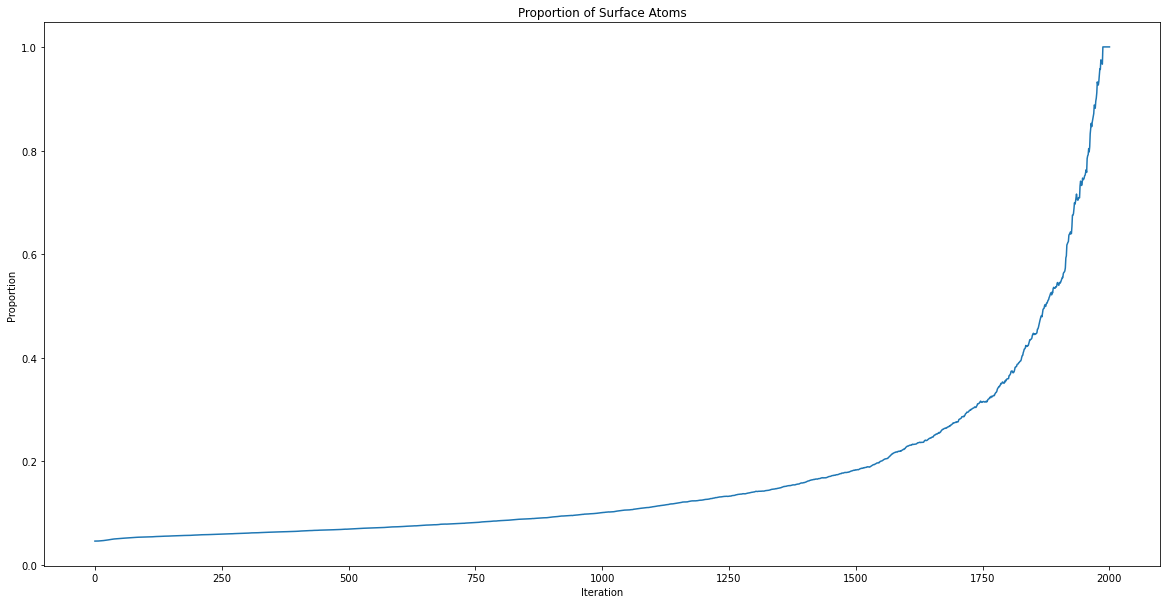

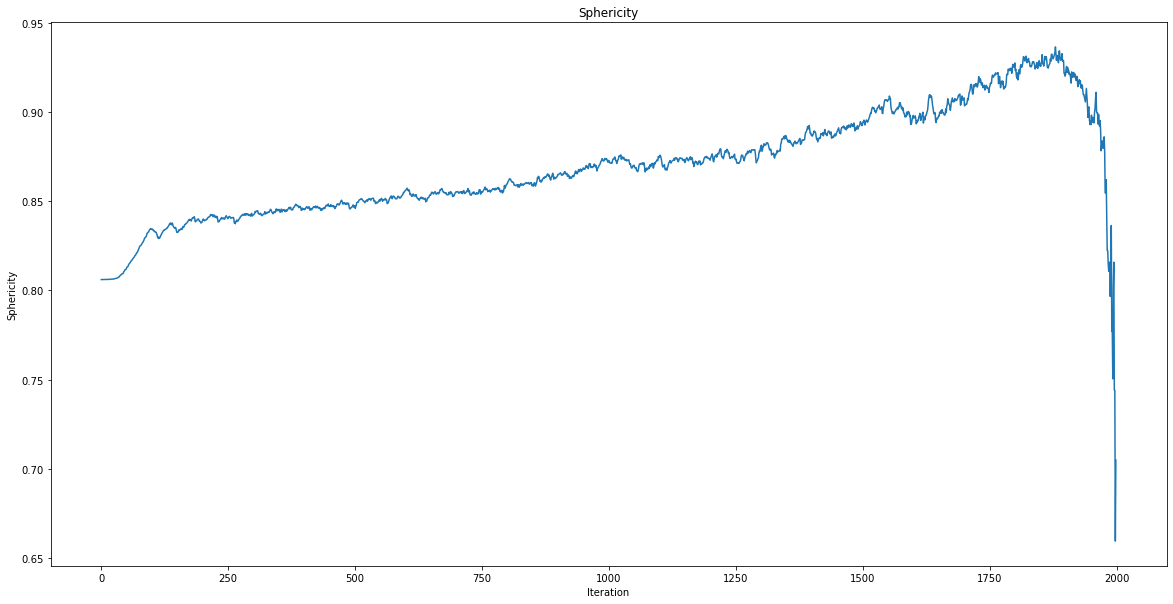

In [46]:
plt.plot(energies)
plt.title(f'Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()

plt.plot(size_atoms)
plt.title(f'Number of Atoms')
plt.xlabel('Number')
plt.ylabel('Energy')
plt.show()

plt.plot(energies[:-1]/size_atoms[:-1])
plt.title(f'Energy per Atom')
plt.xlabel('Iteration')
plt.ylabel('Energy per atom')
plt.show()

plt.plot(surface_size[:-1]/size_atoms[:-1])
plt.title(f'Proportion of Surface Atoms')
plt.xlabel('Iteration')
plt.ylabel('Proportion')
plt.show()

plt.plot(sphericity)
plt.title(f'Sphericity')
plt.xlabel('Iteration')
plt.ylabel('Sphericity')
plt.show()

# Simulation Runs

In [47]:
# This is only run to produce the gif and snapshots: takes around 2.5m
_= sublimation_sim(kT = 0.75, seed=1, plot_snap=True, plot_hulls=True, plot_gif=True)

## Effects of Varying Temperature

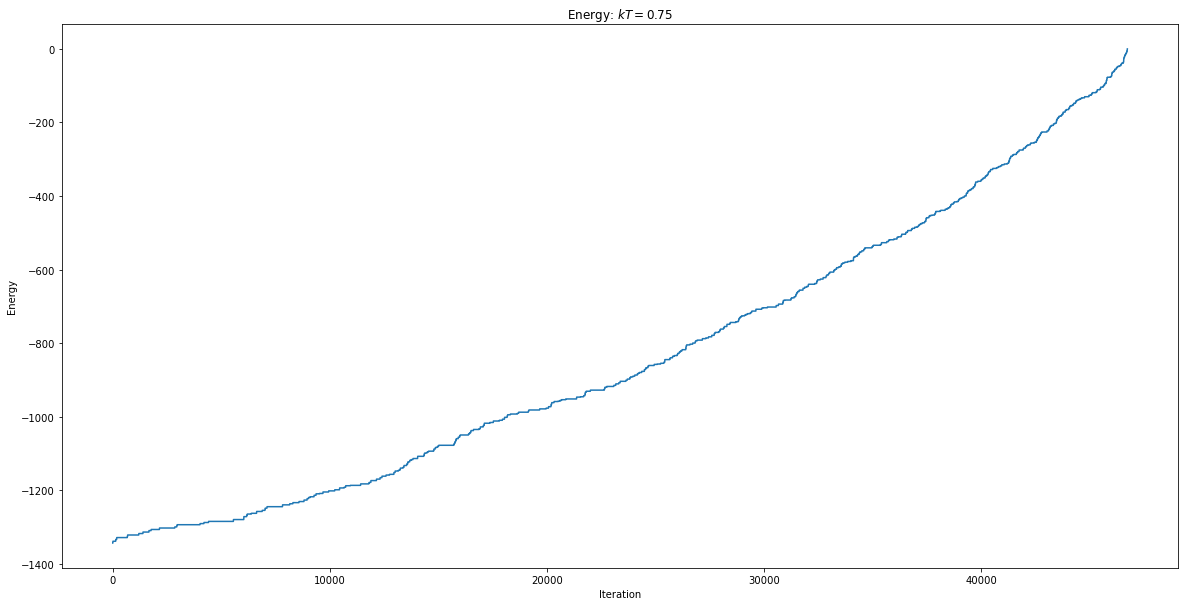

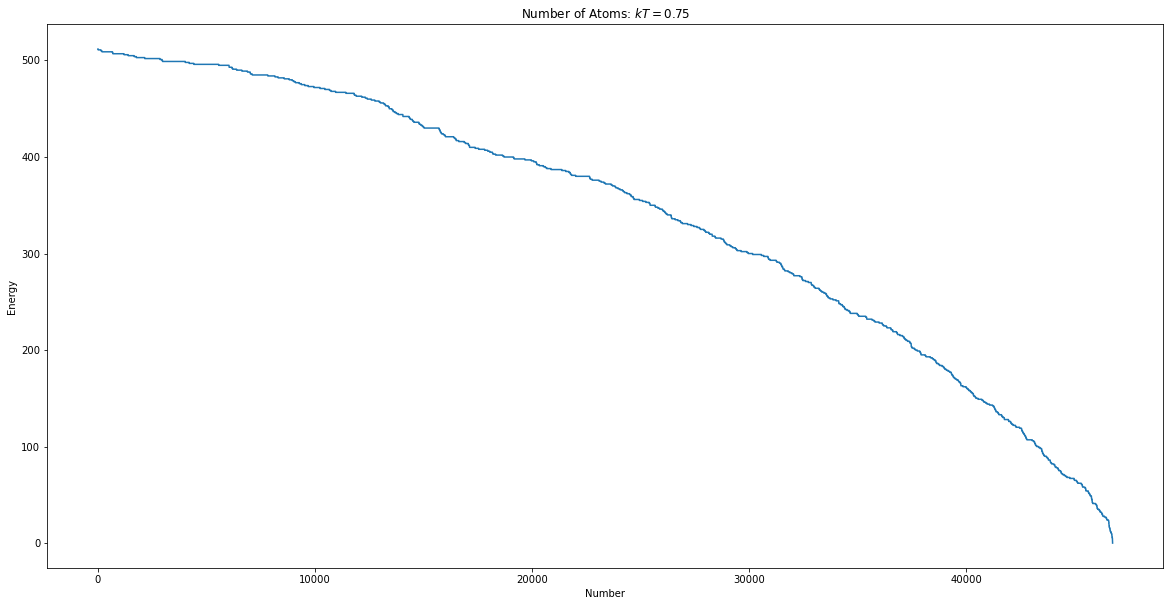

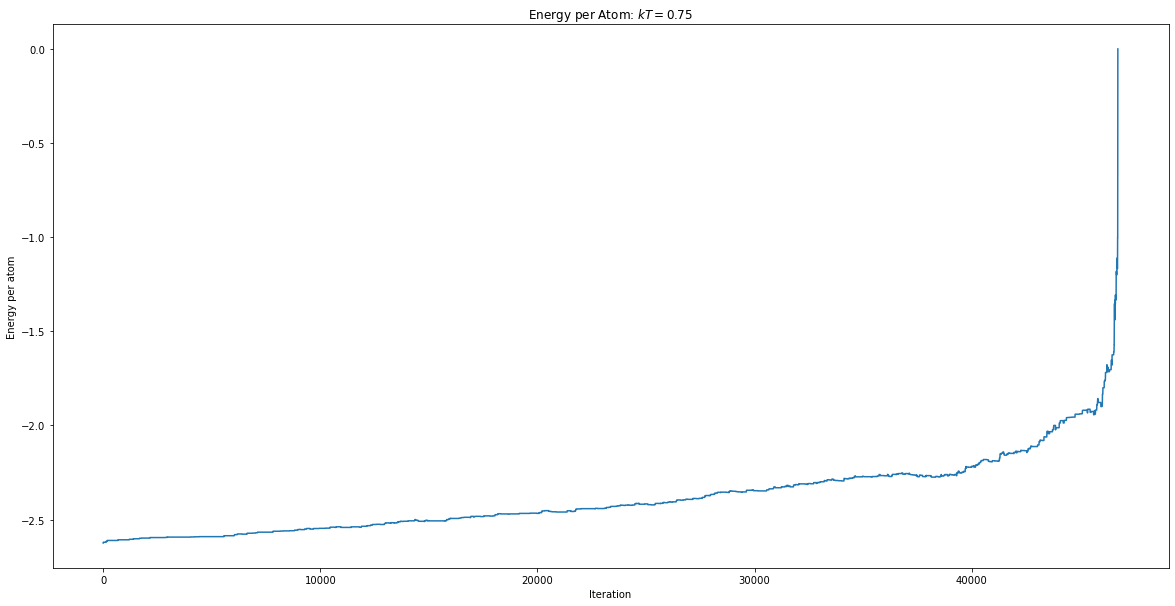

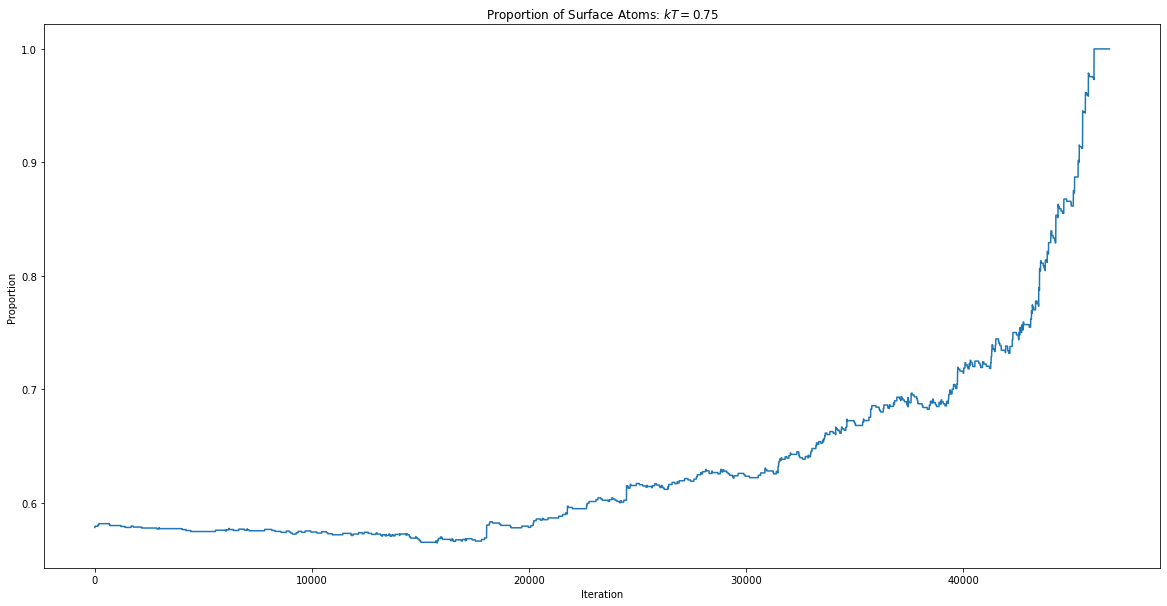

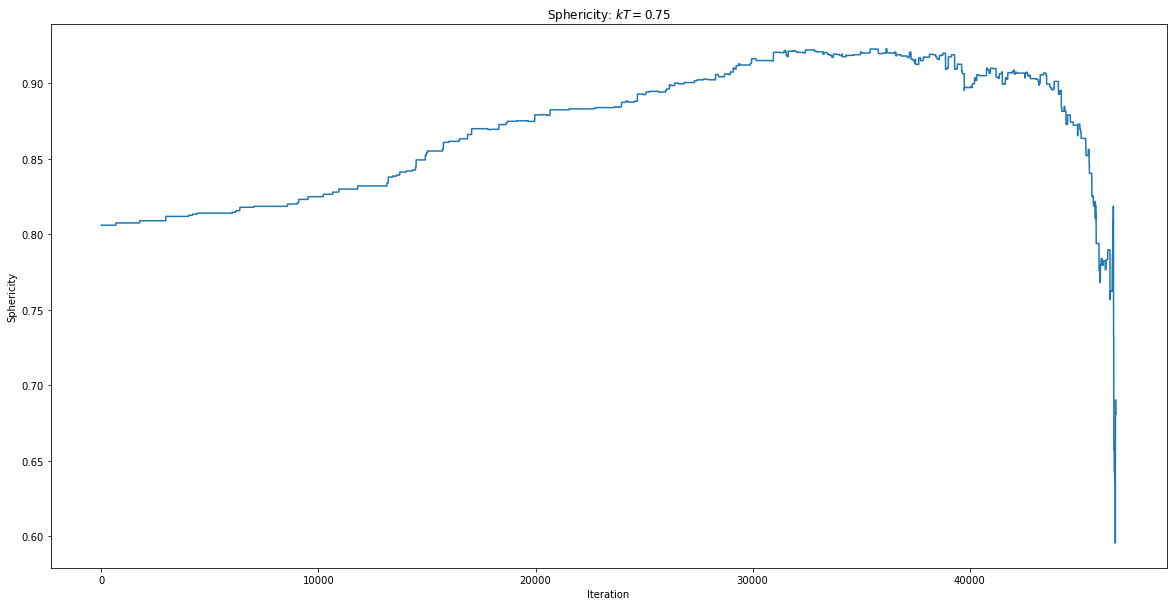

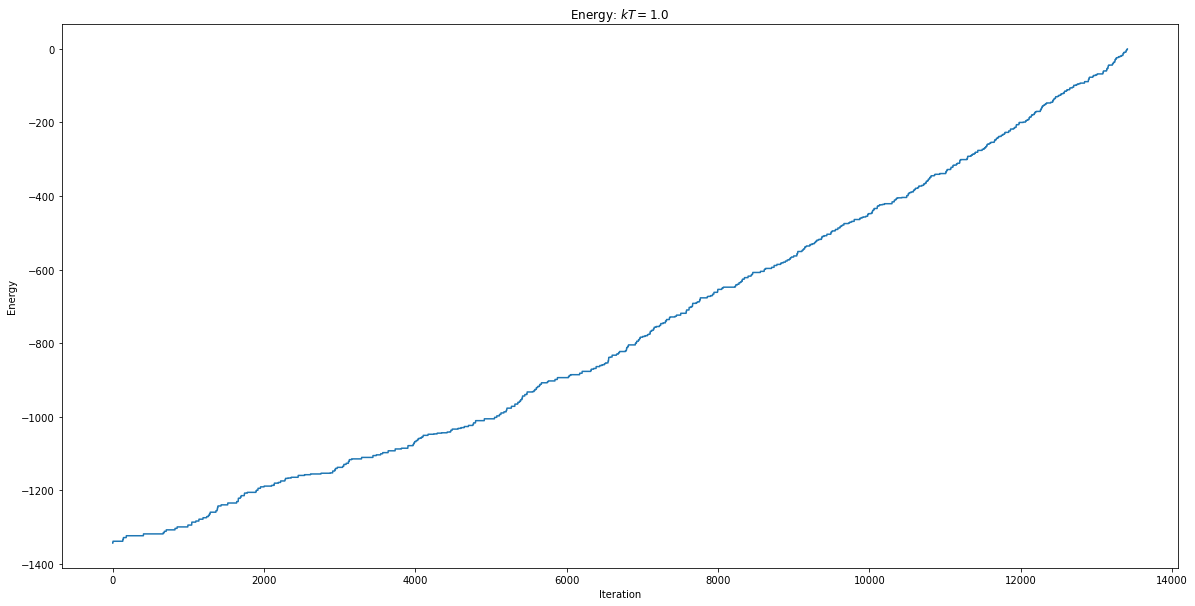

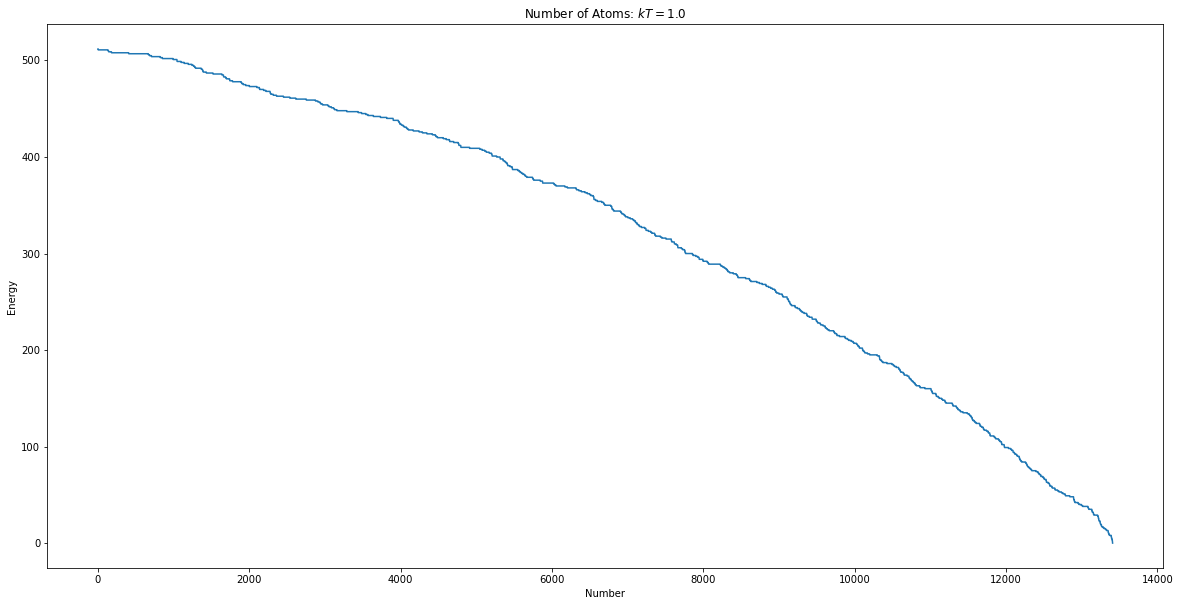

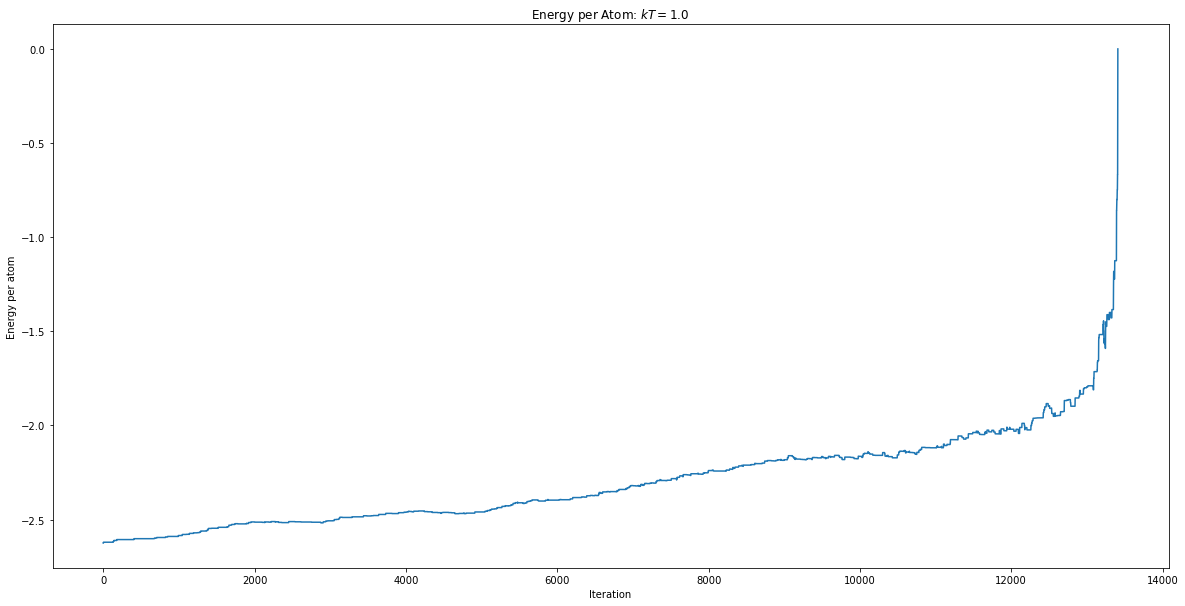

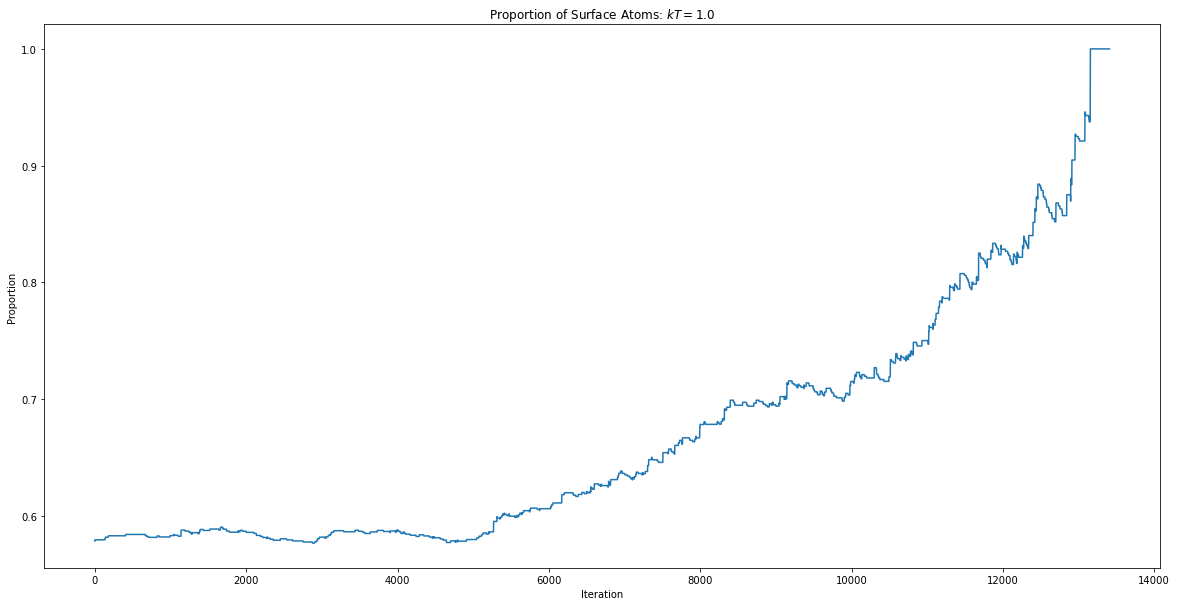

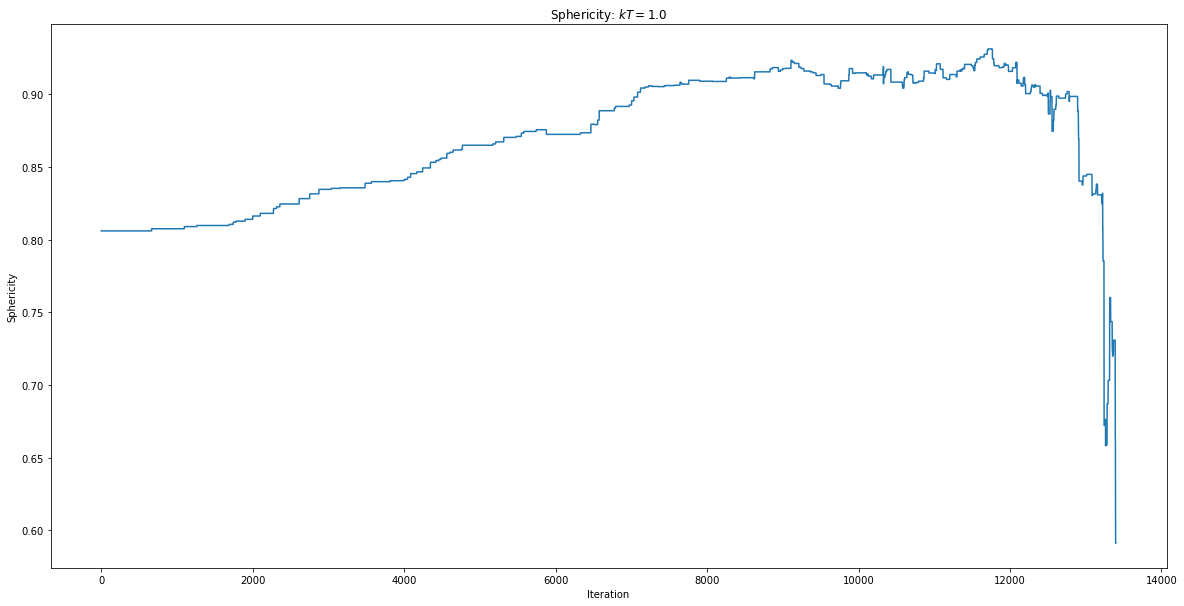

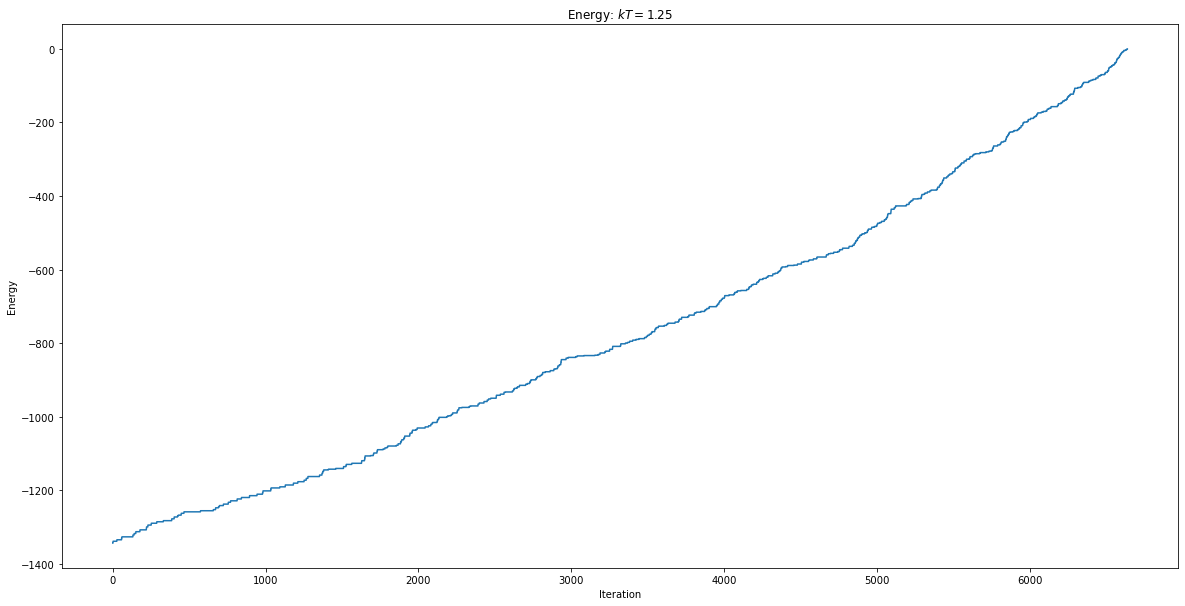

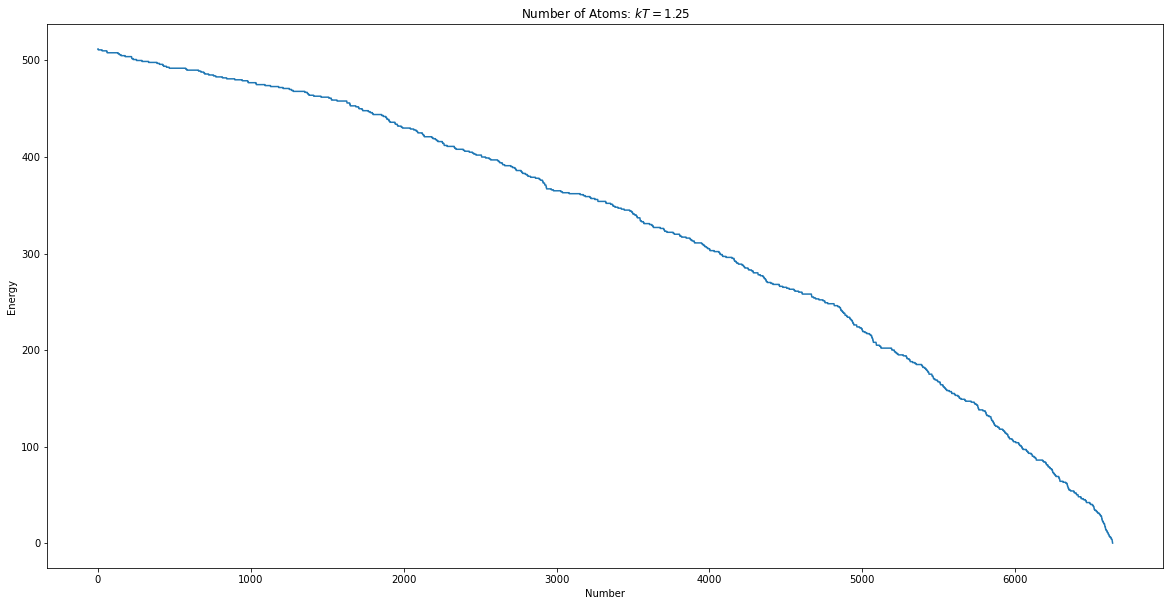

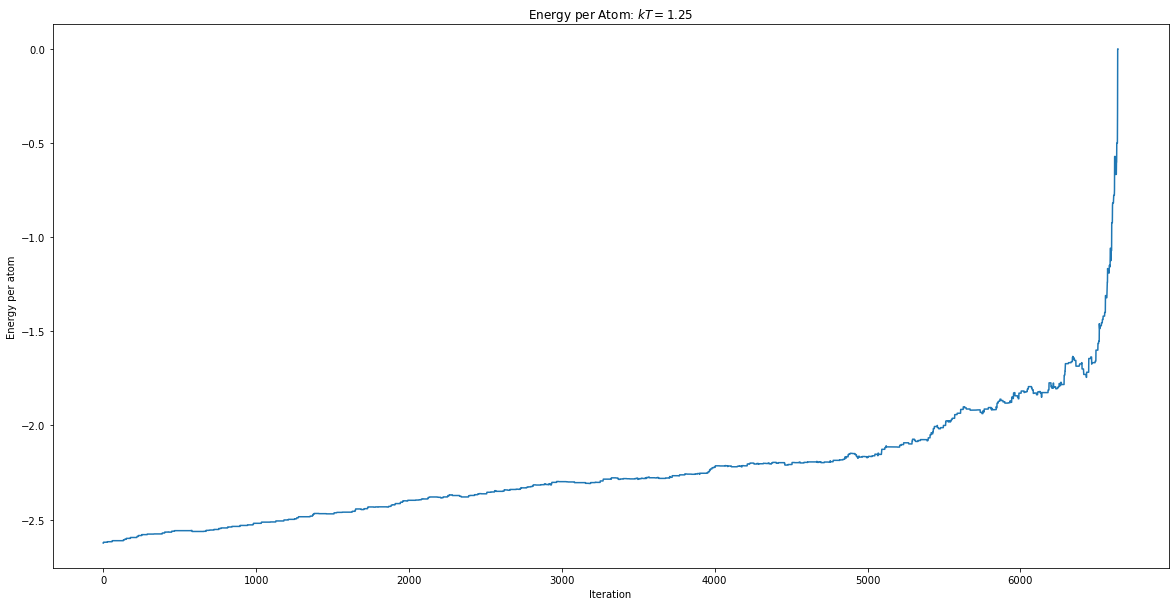

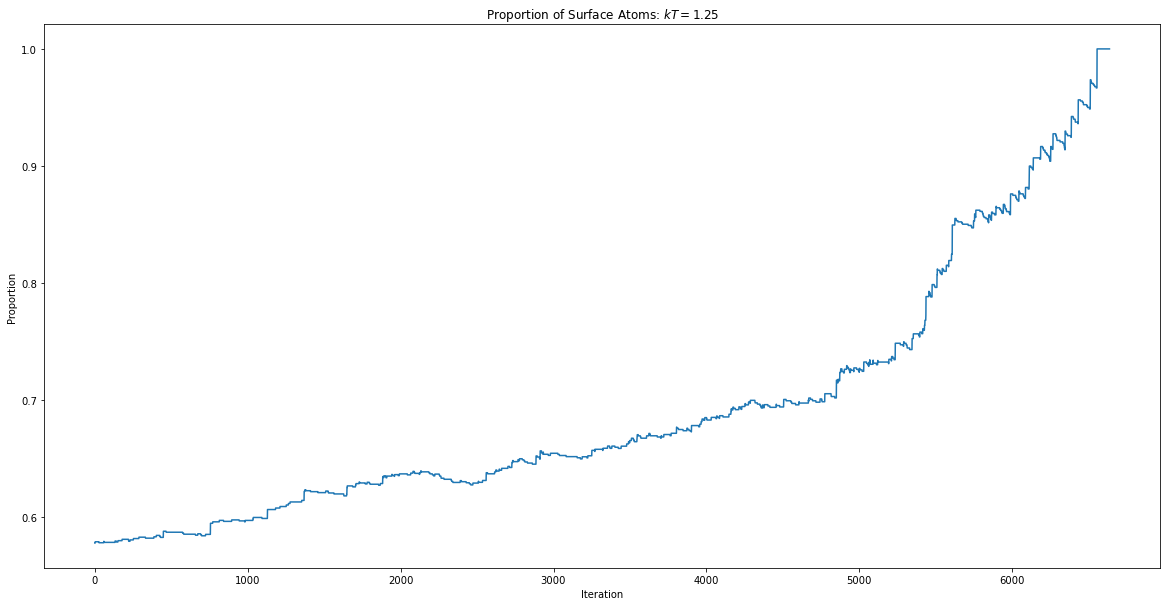

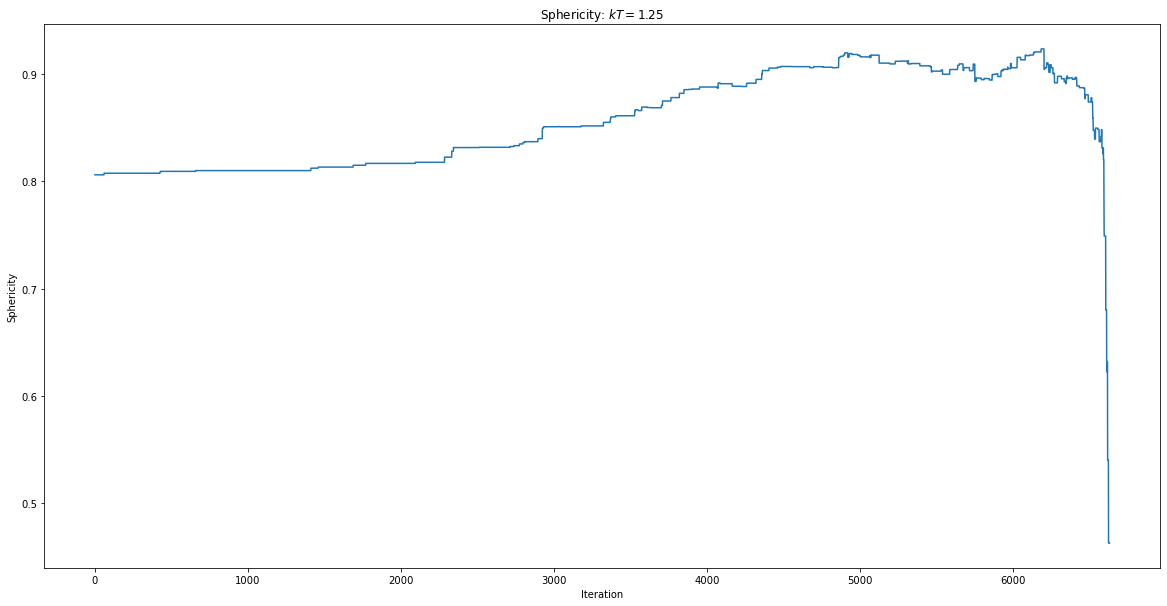

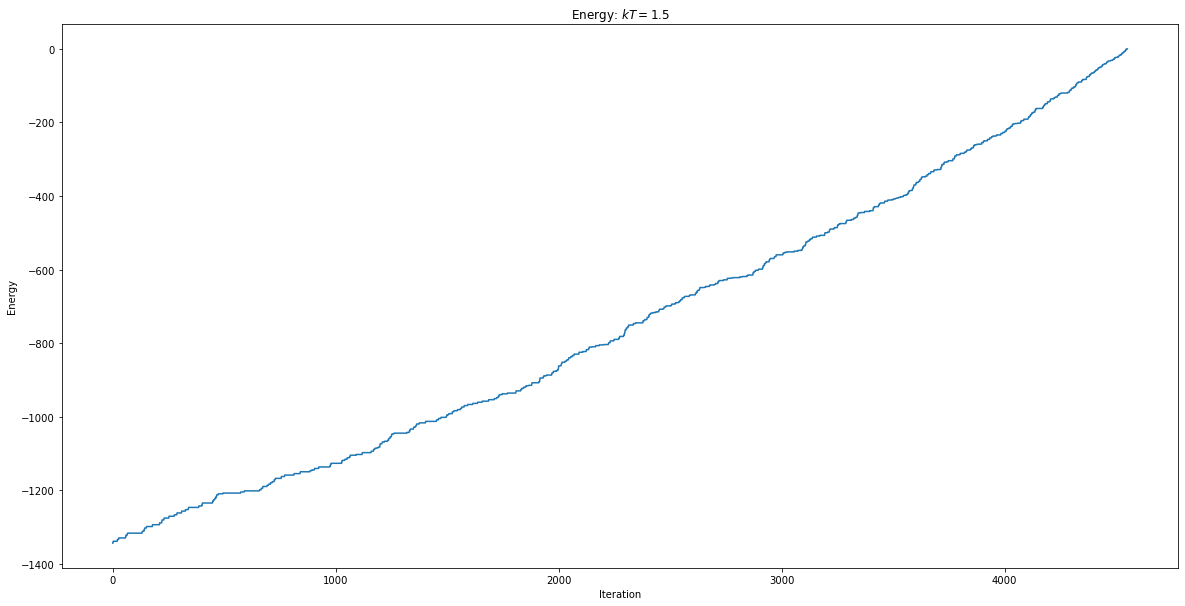

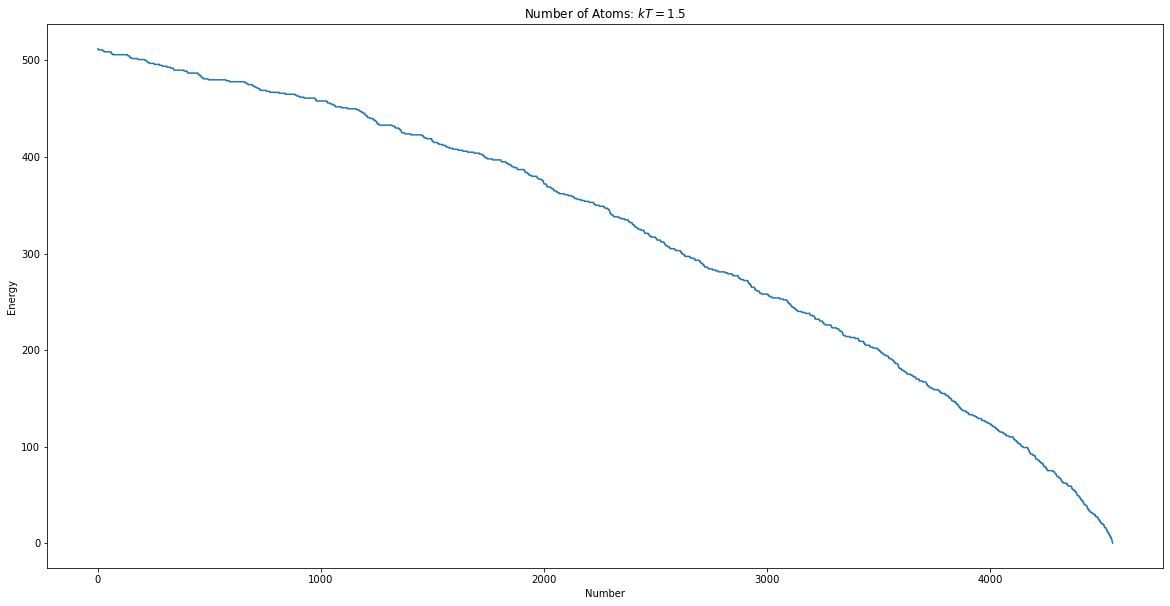

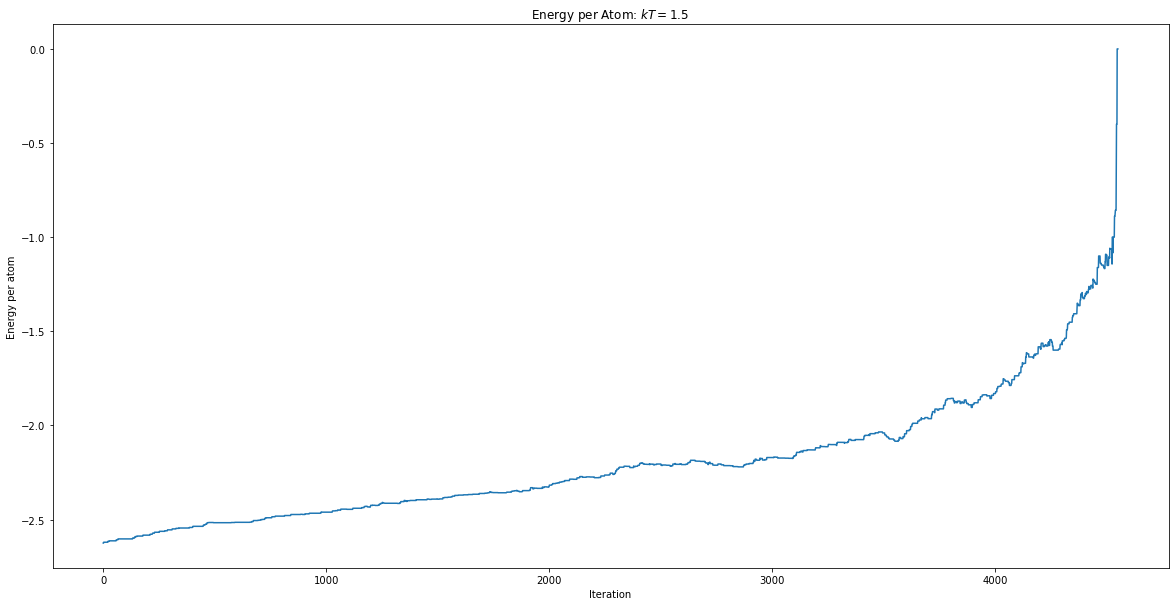

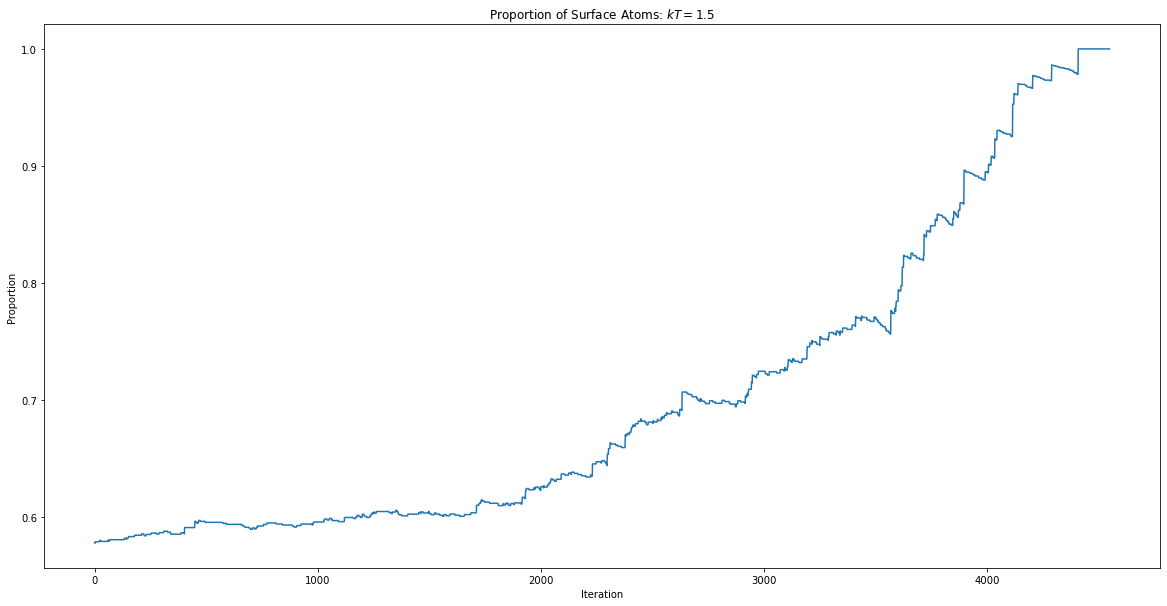

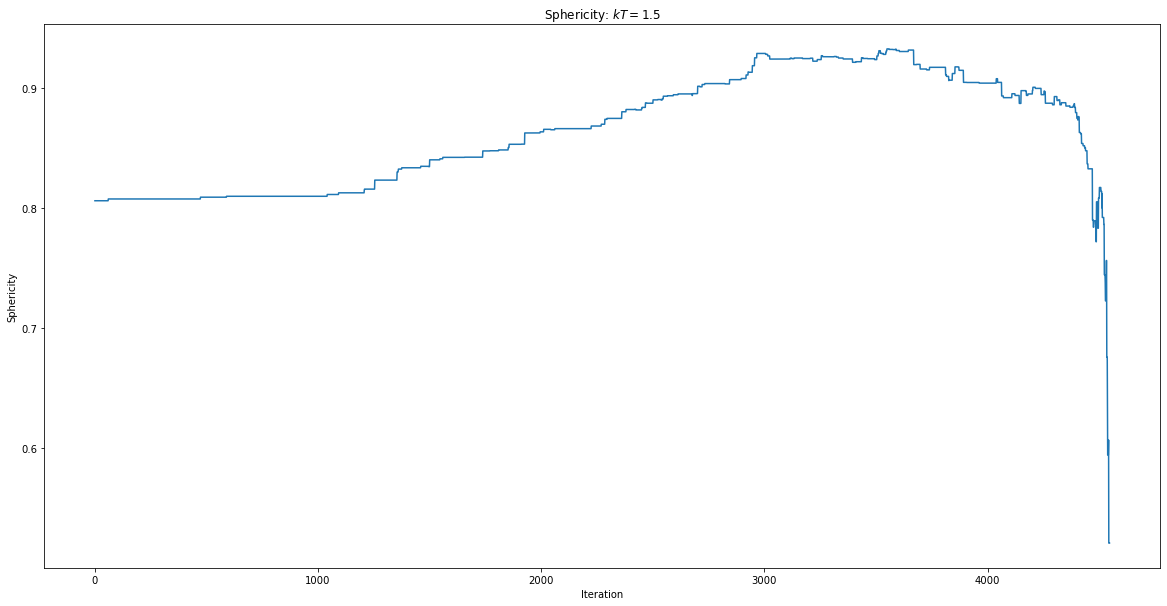

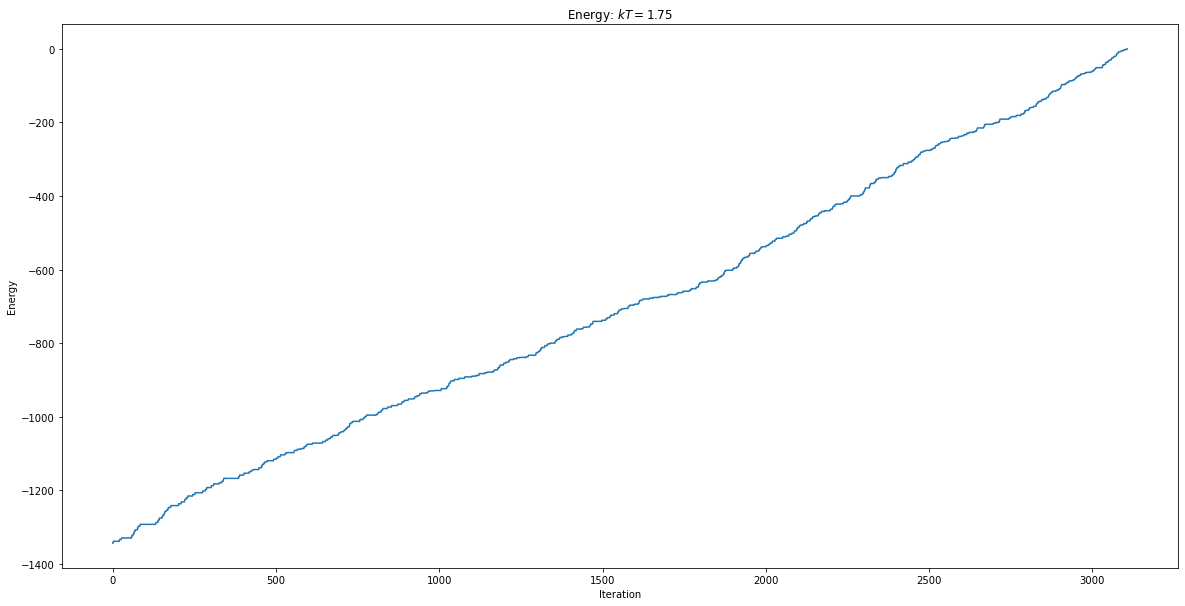

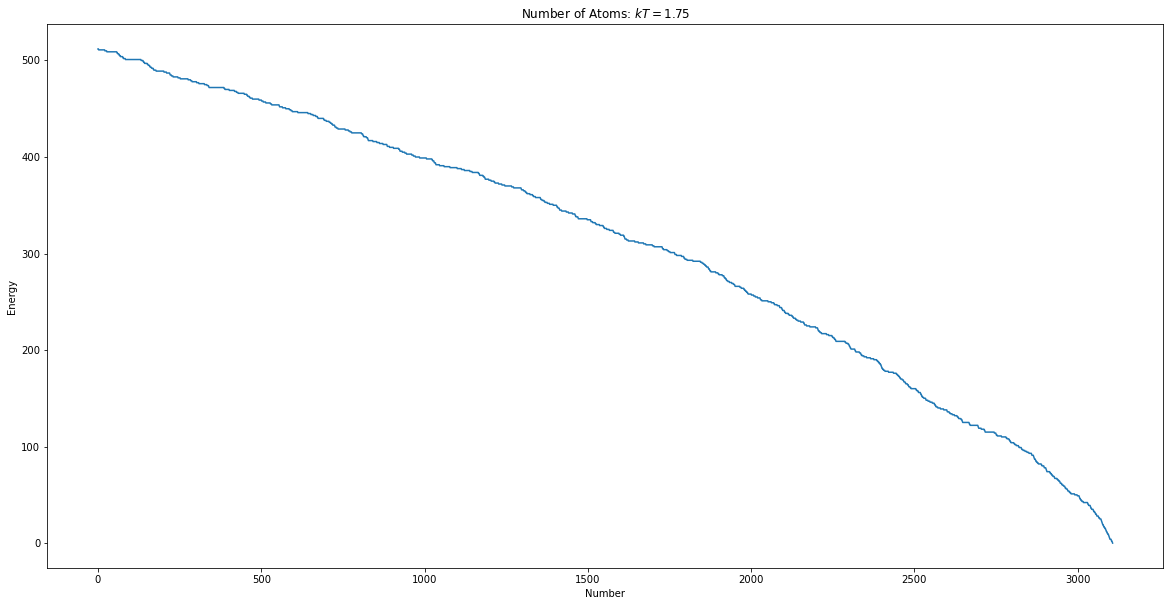

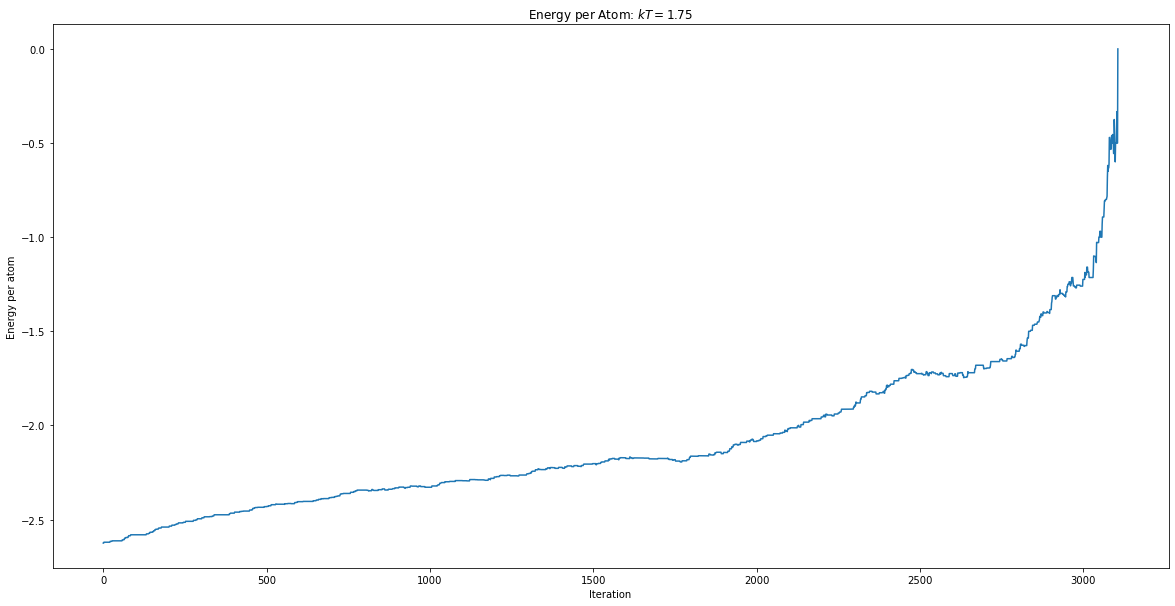

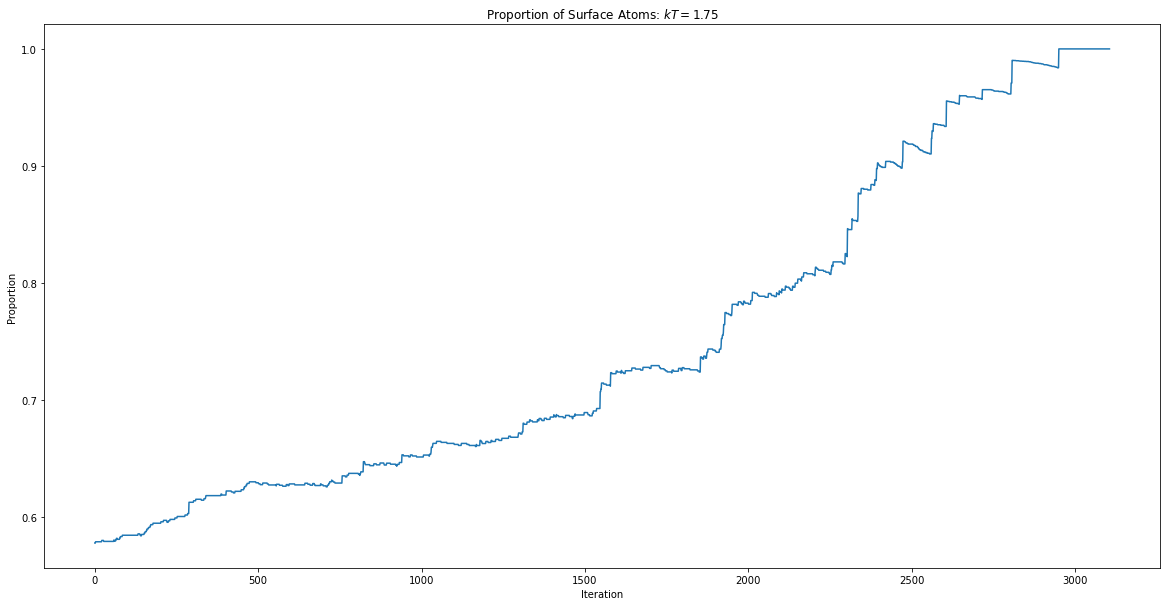

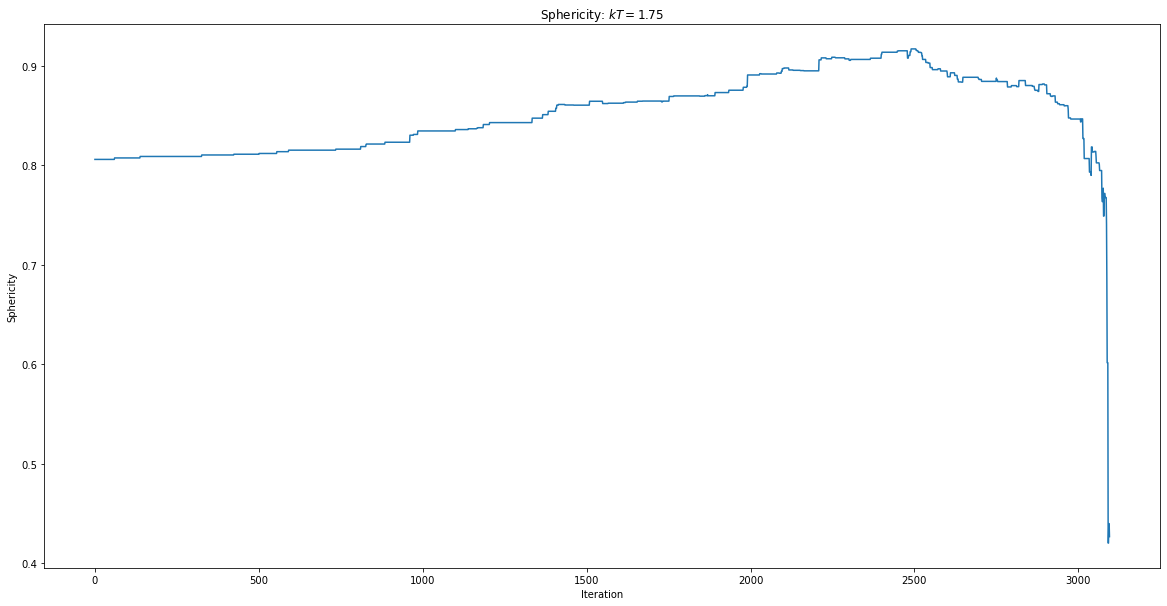

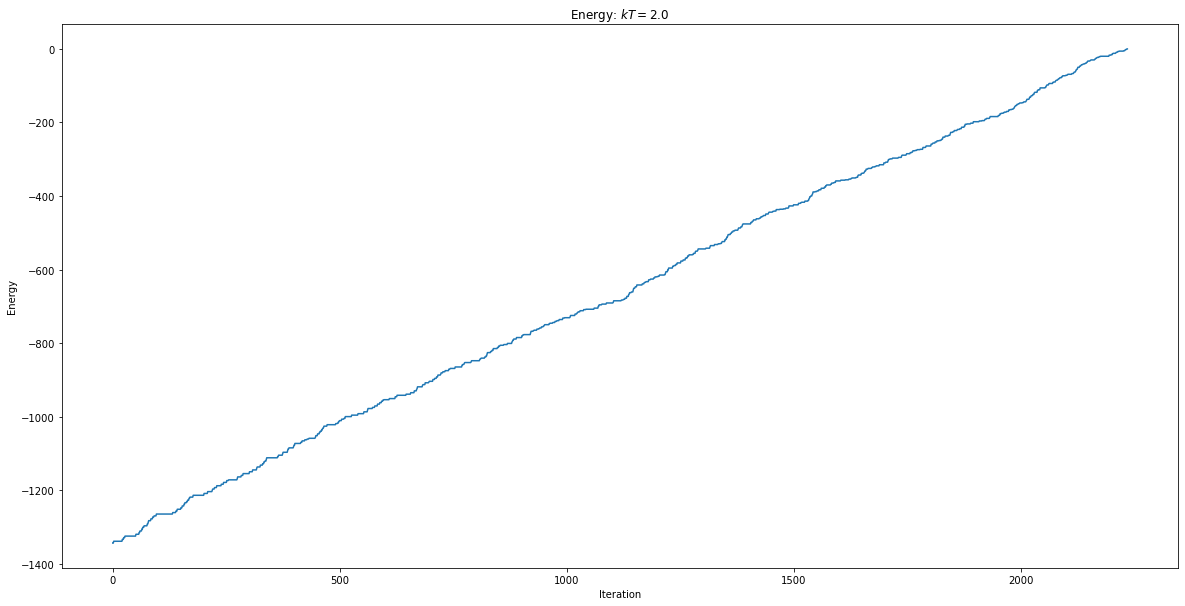

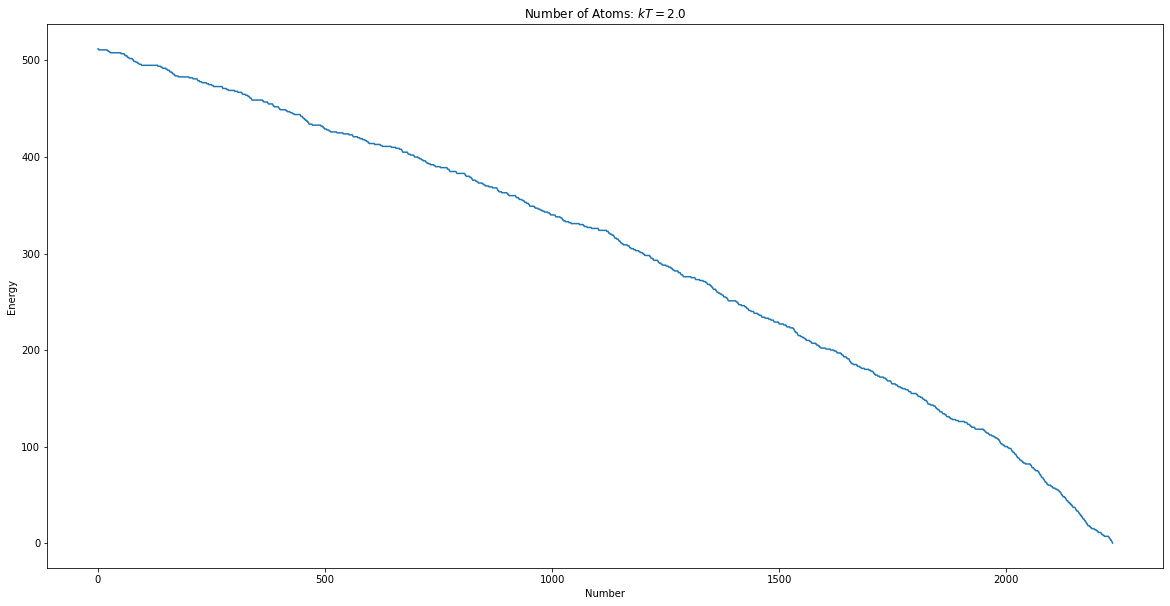

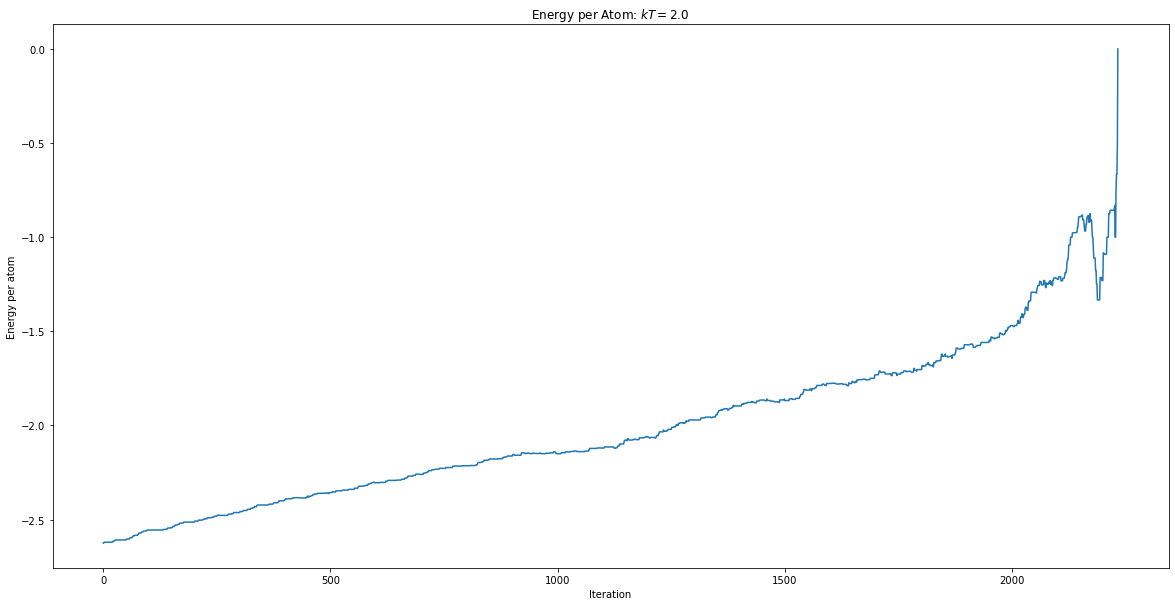

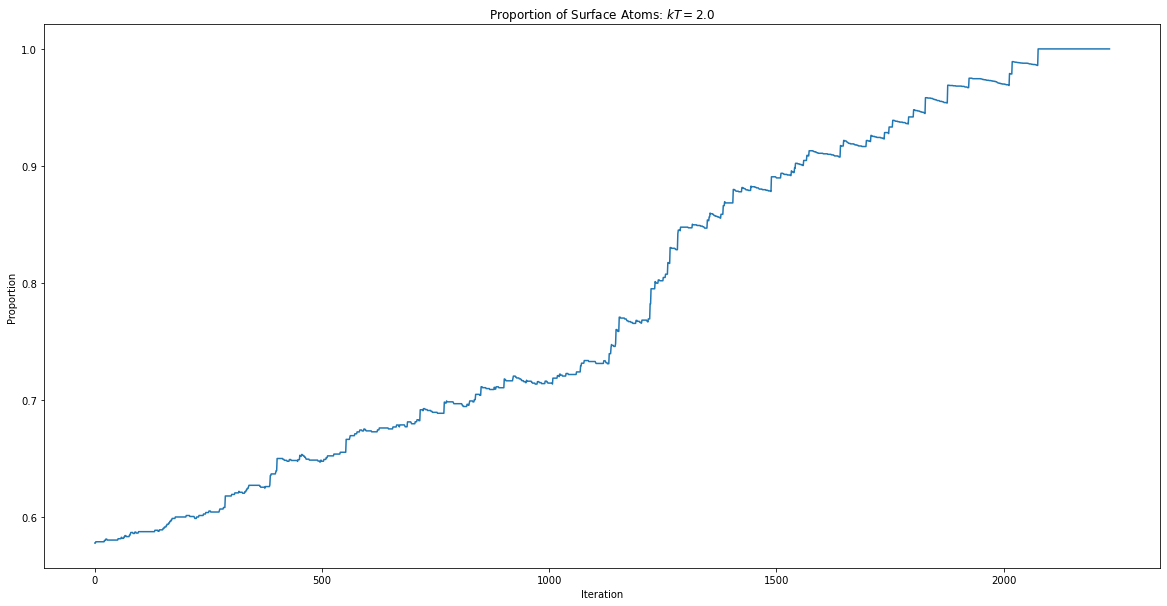

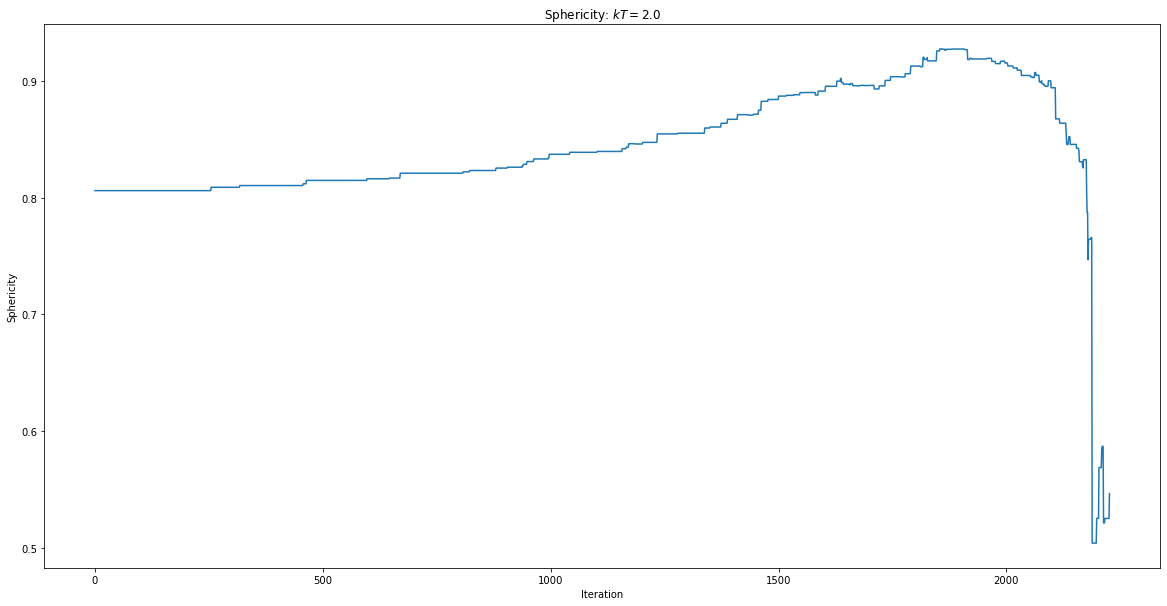

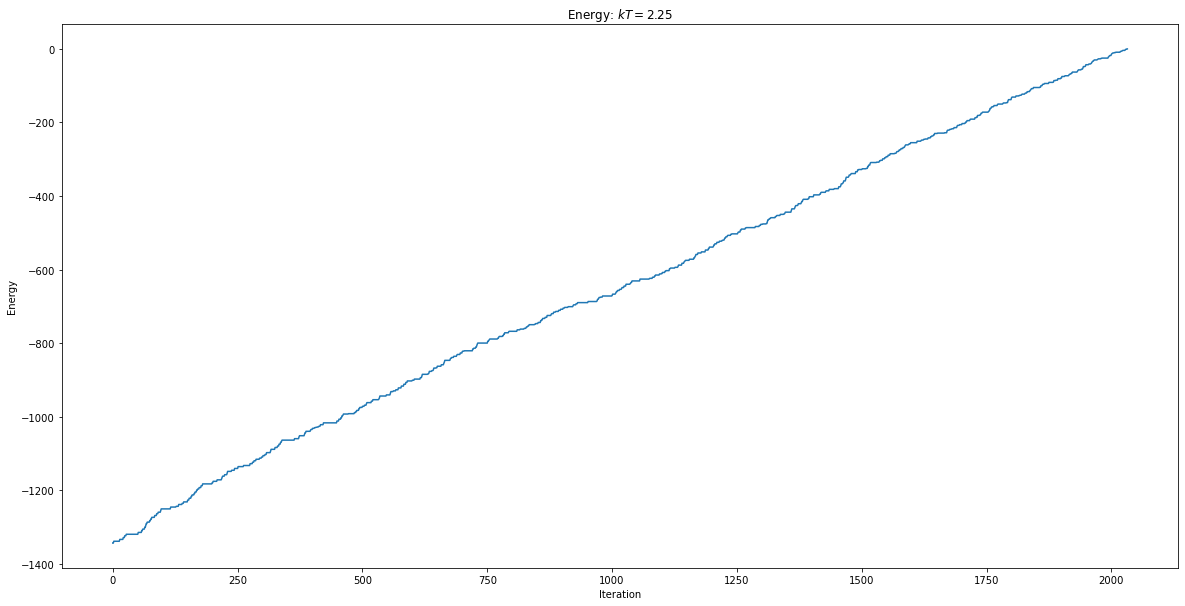

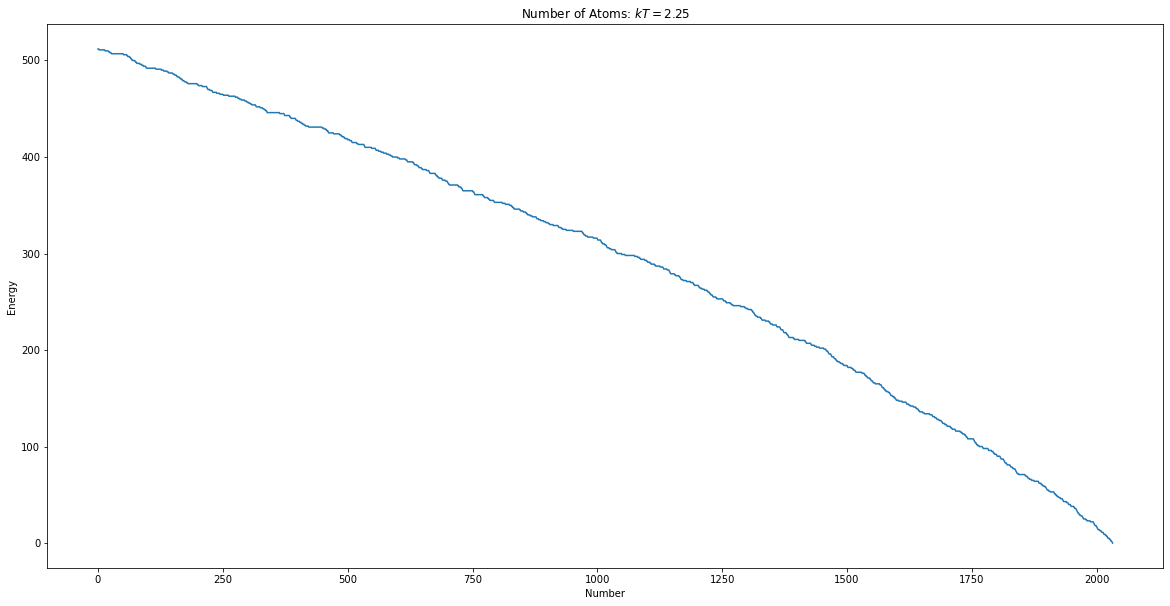

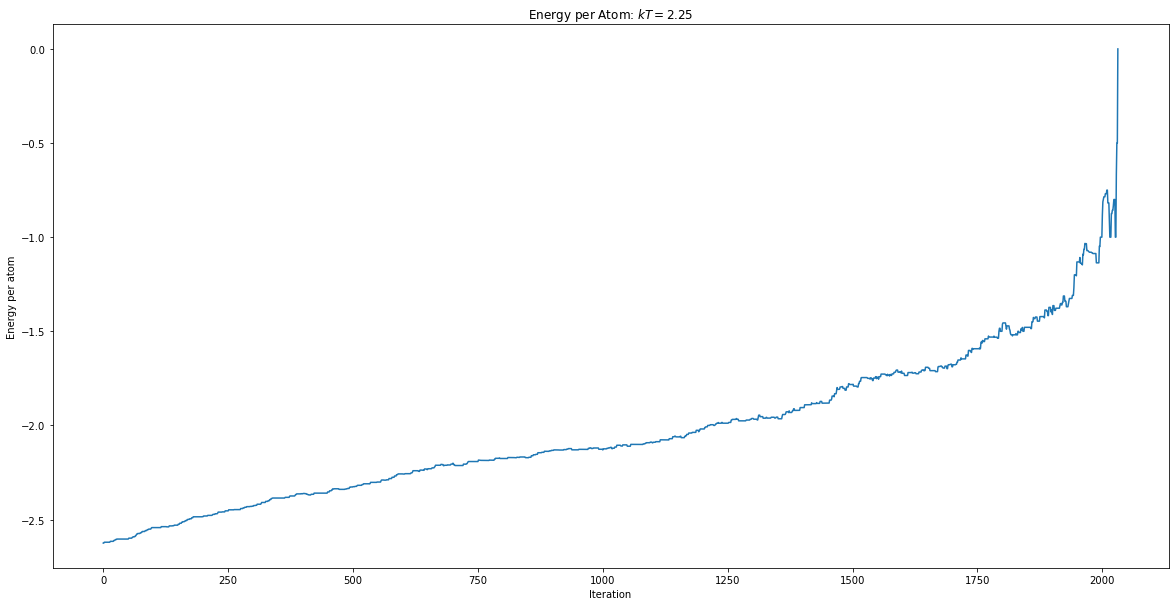

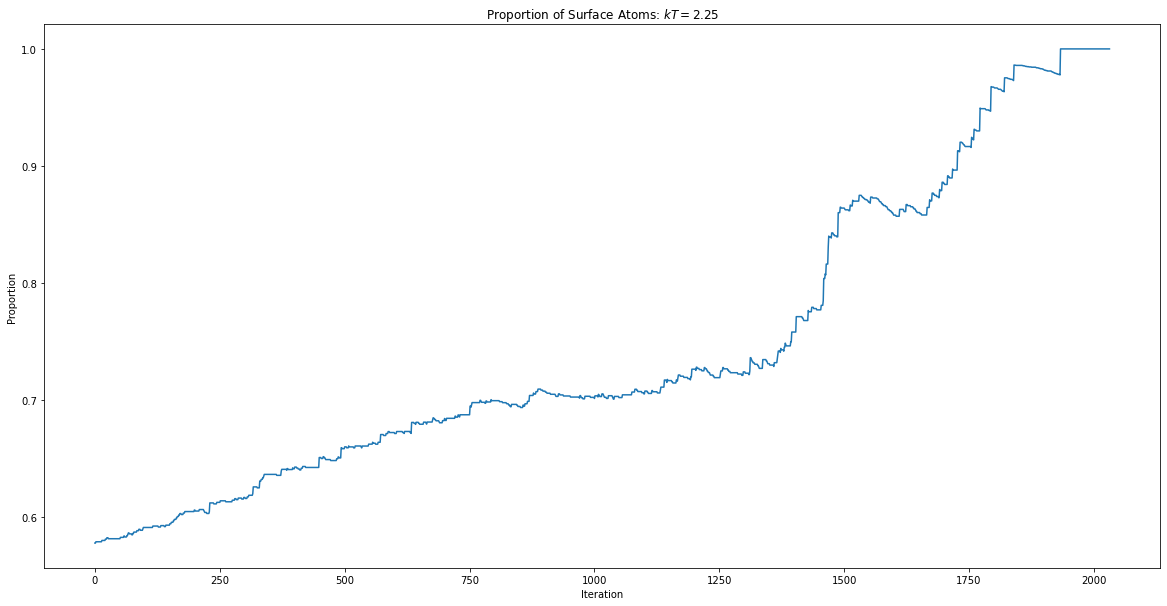

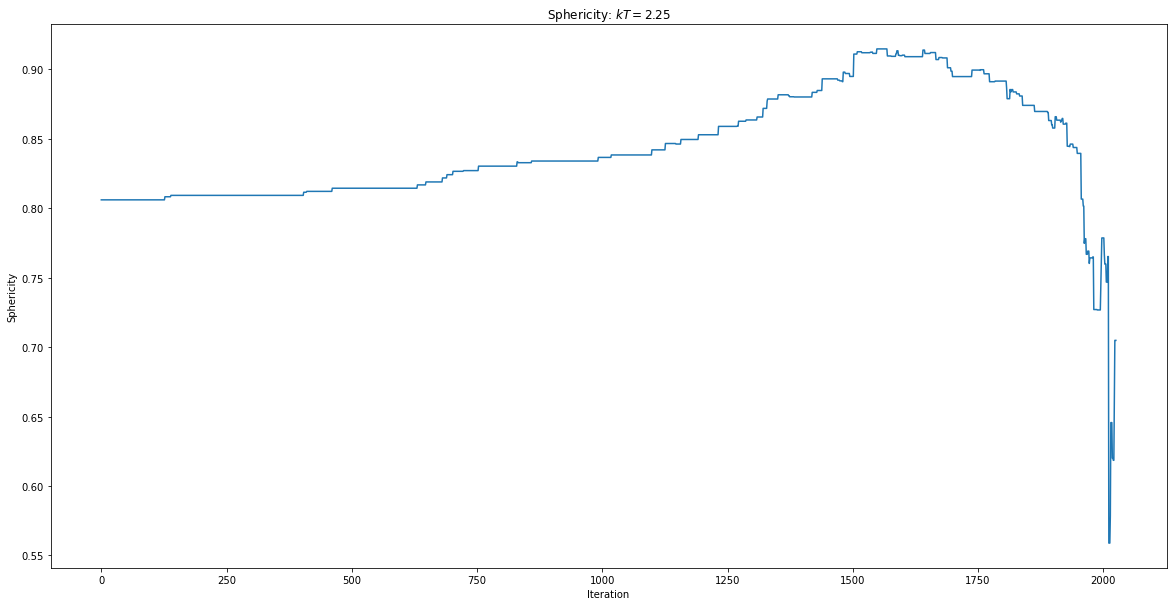

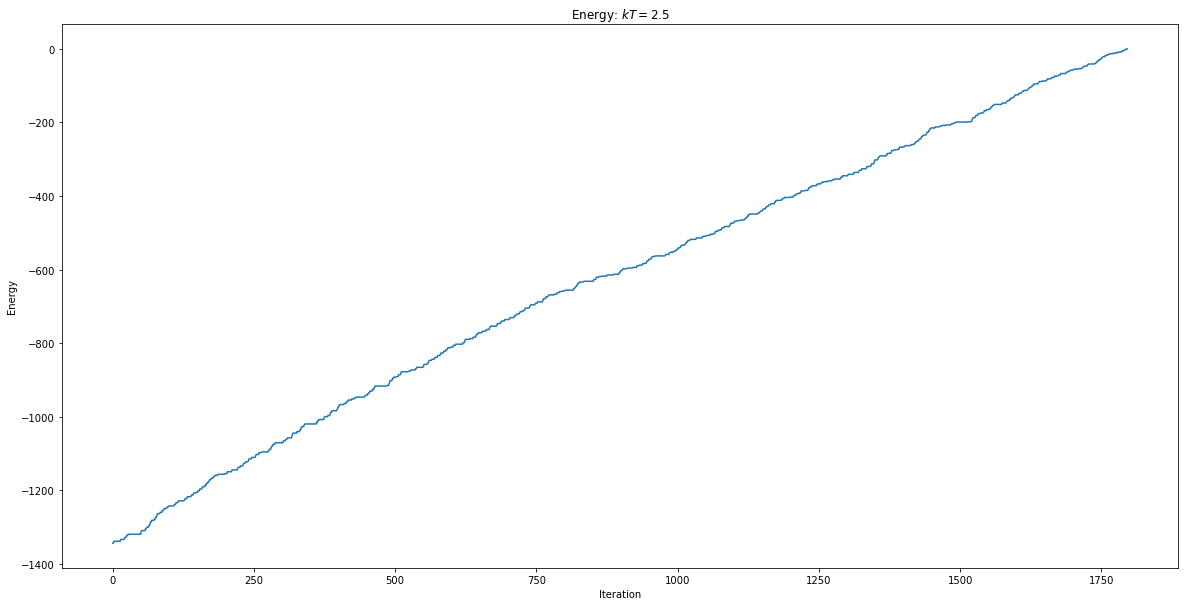

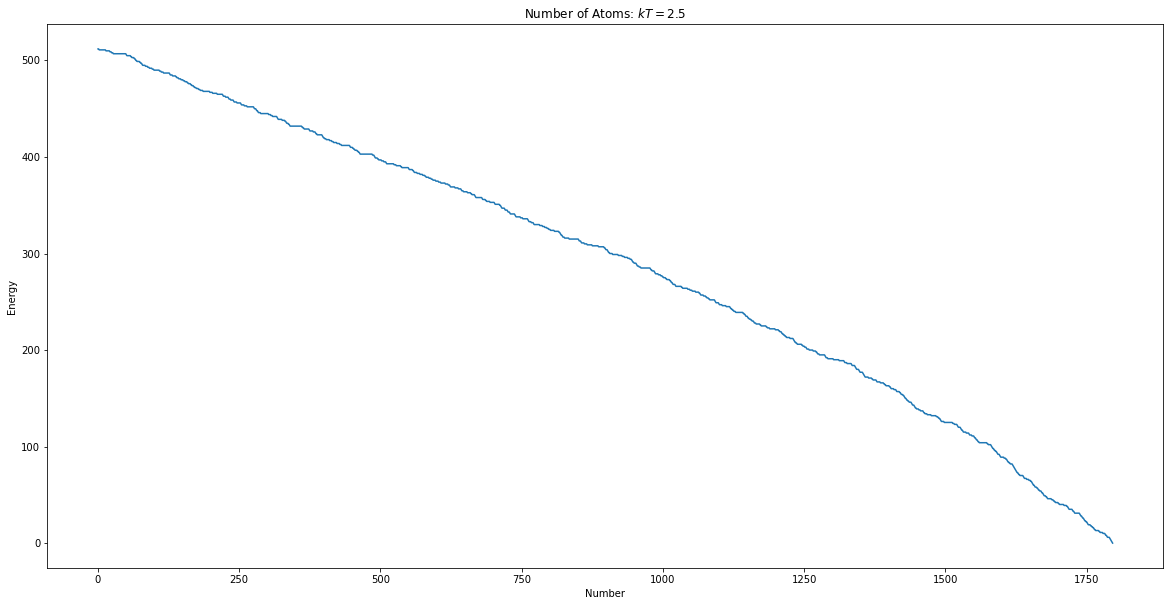

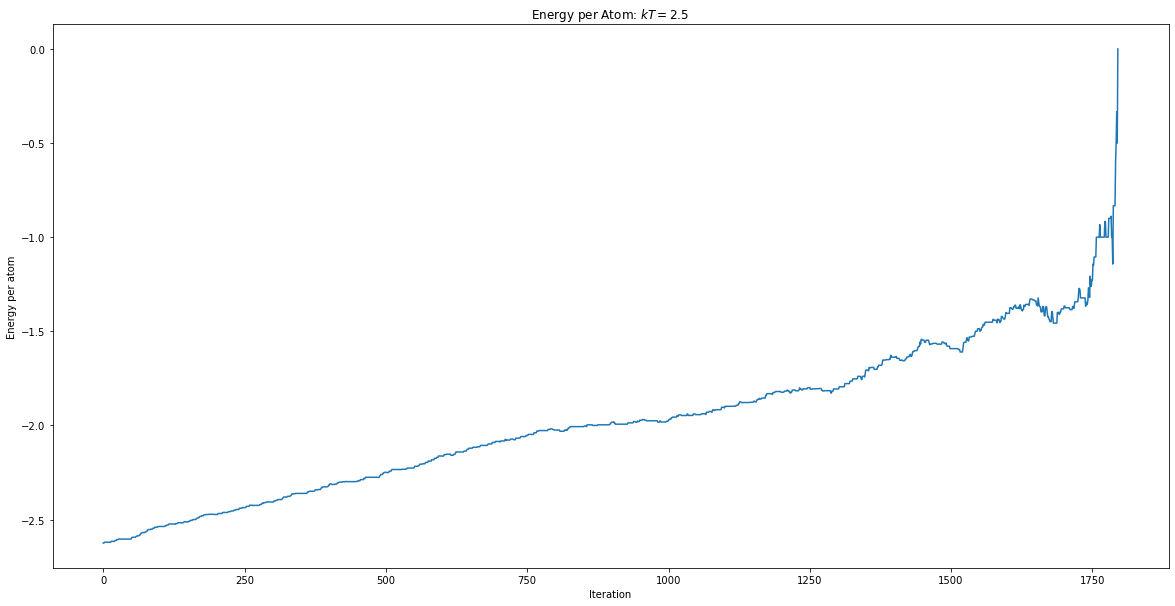

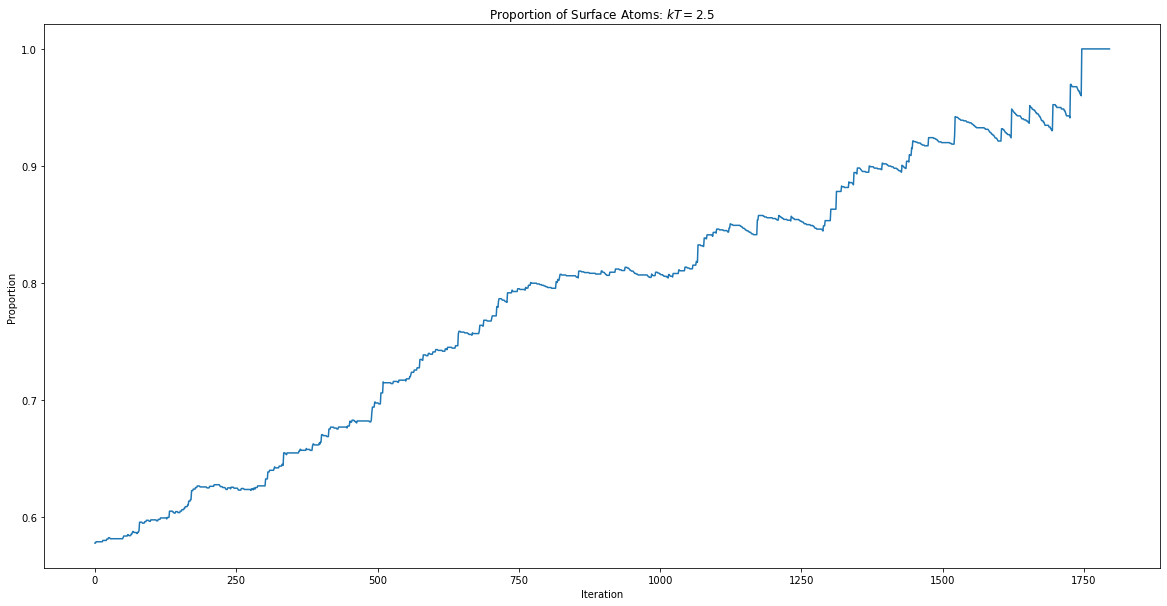

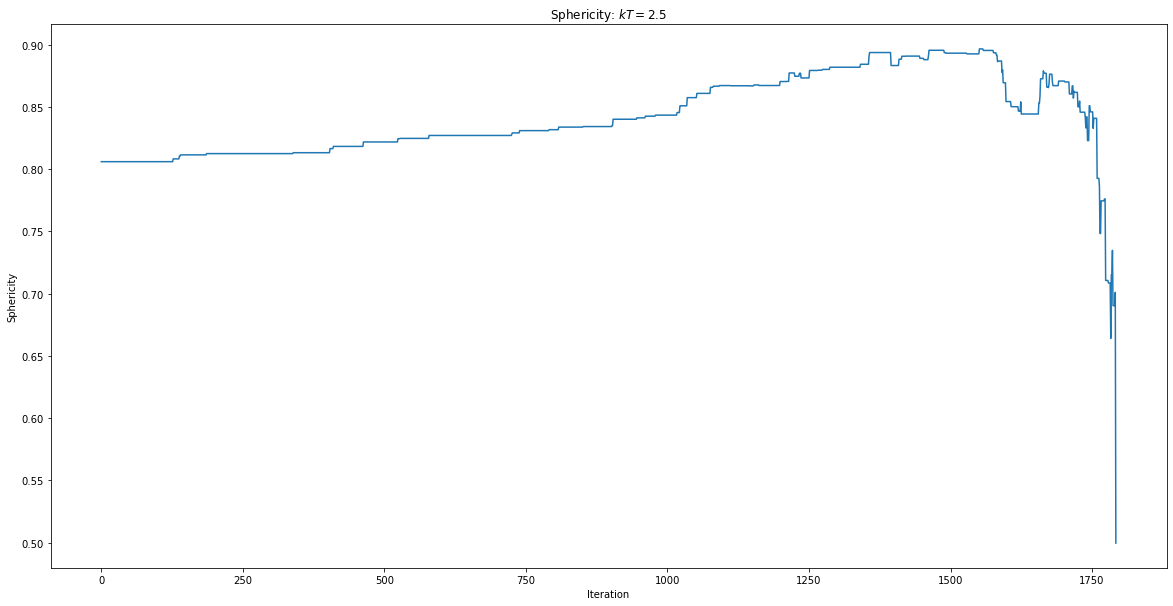

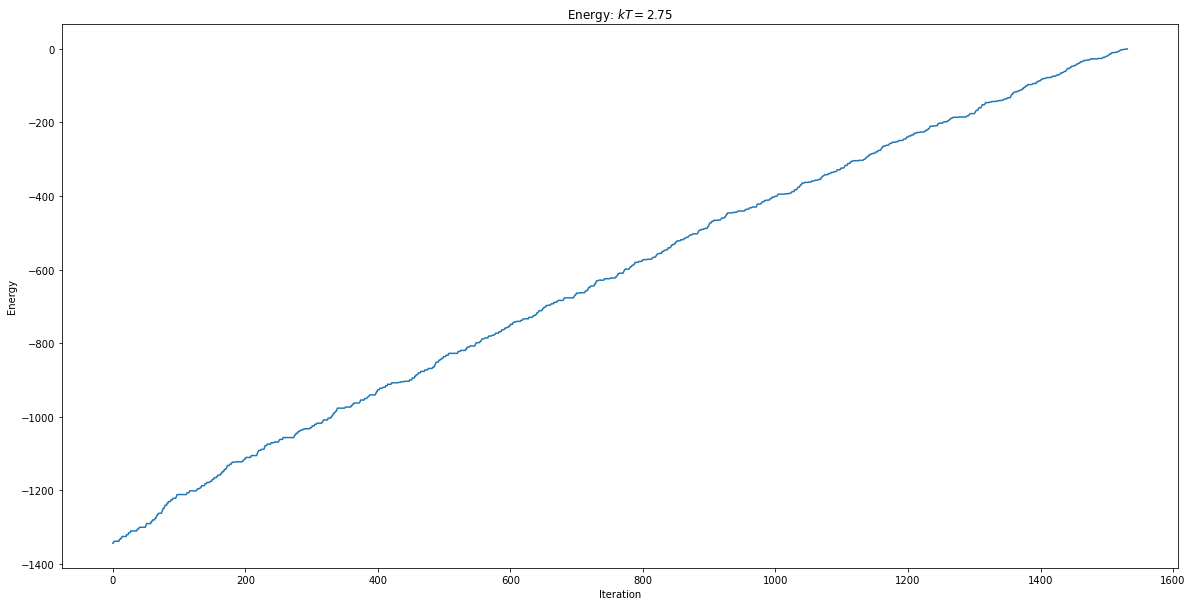

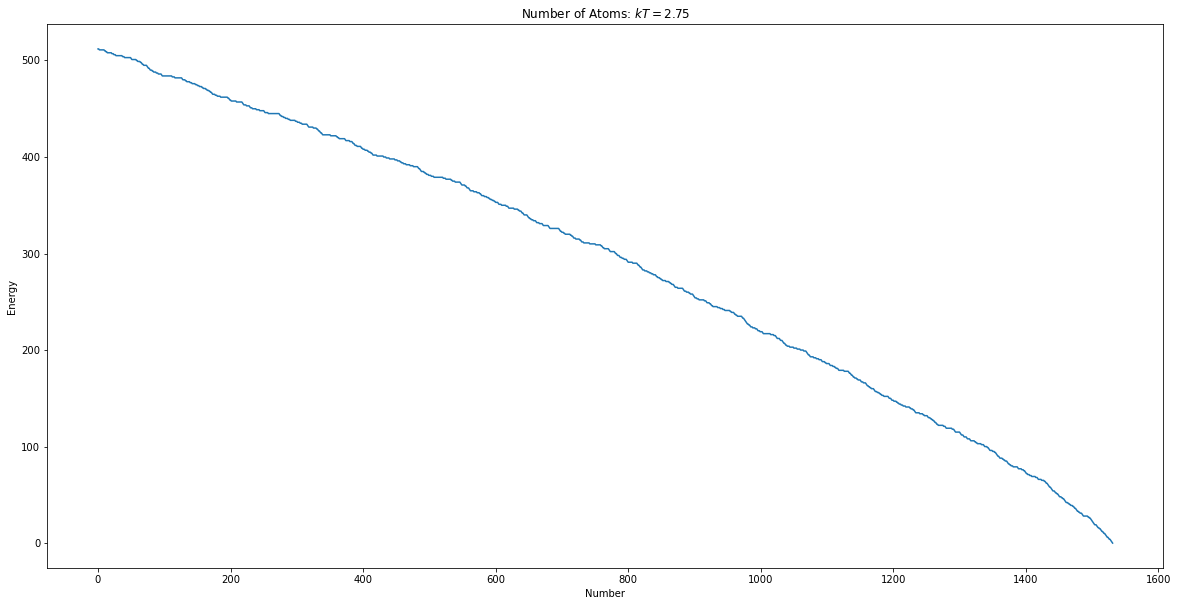

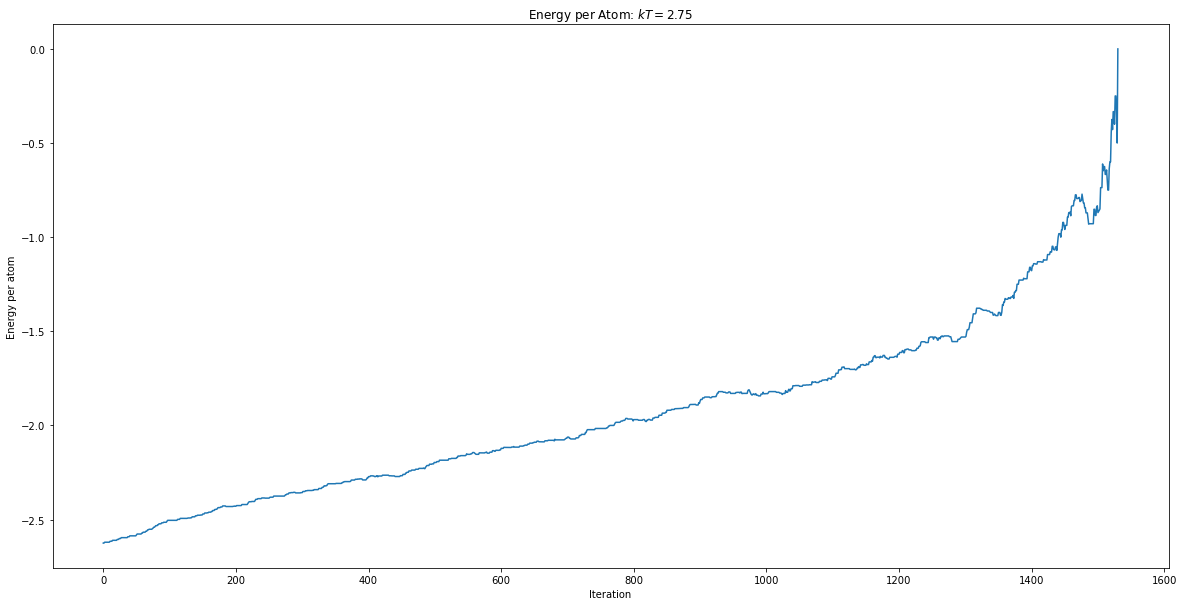

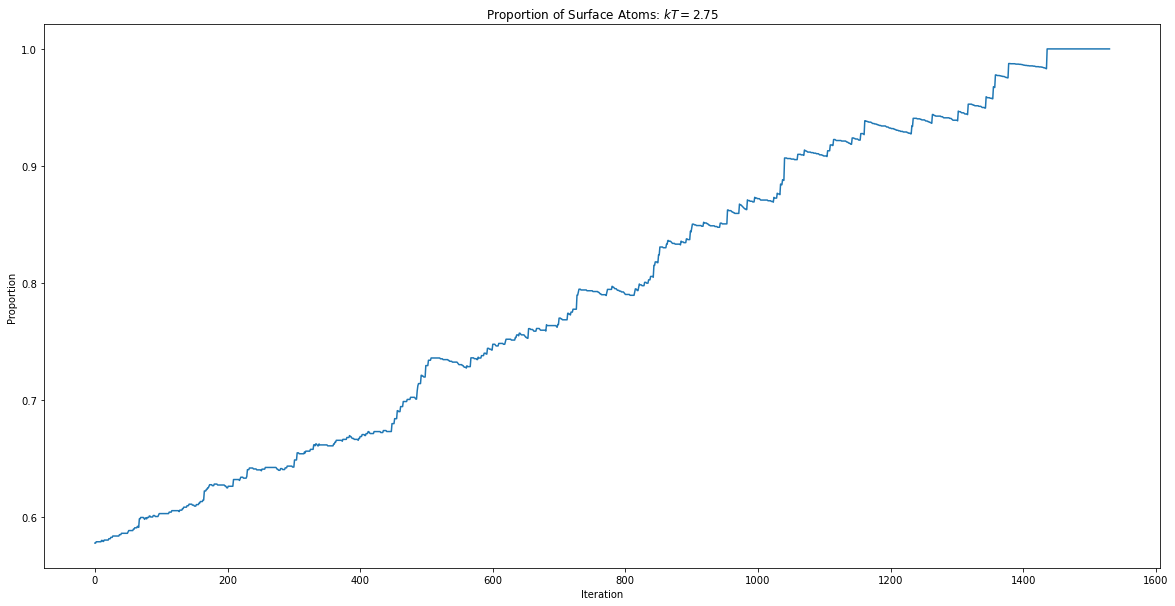

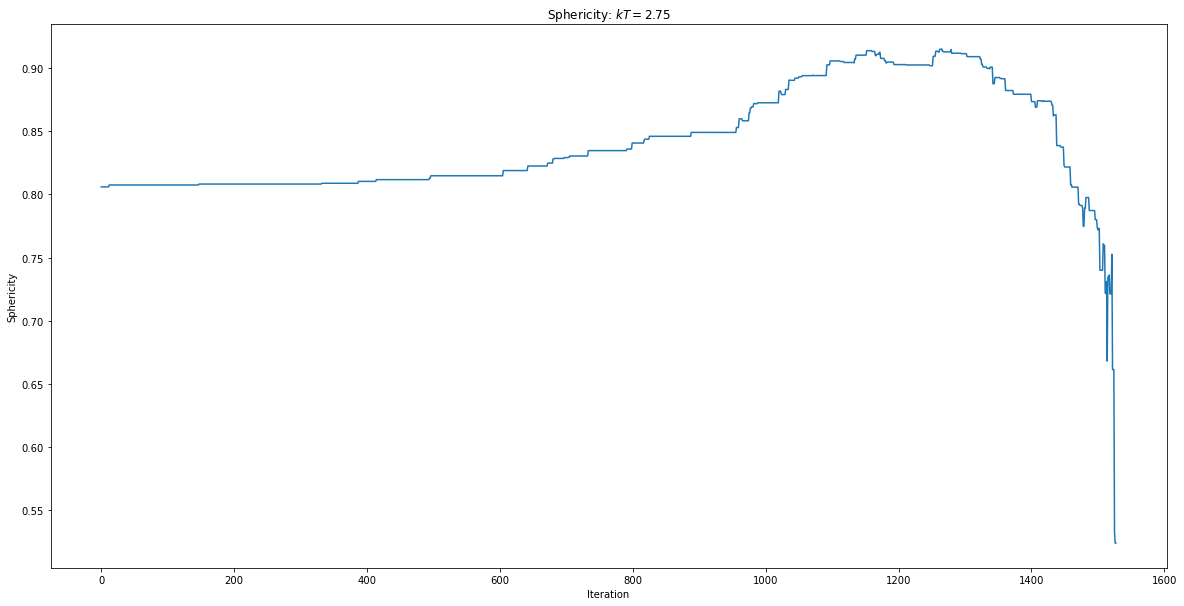

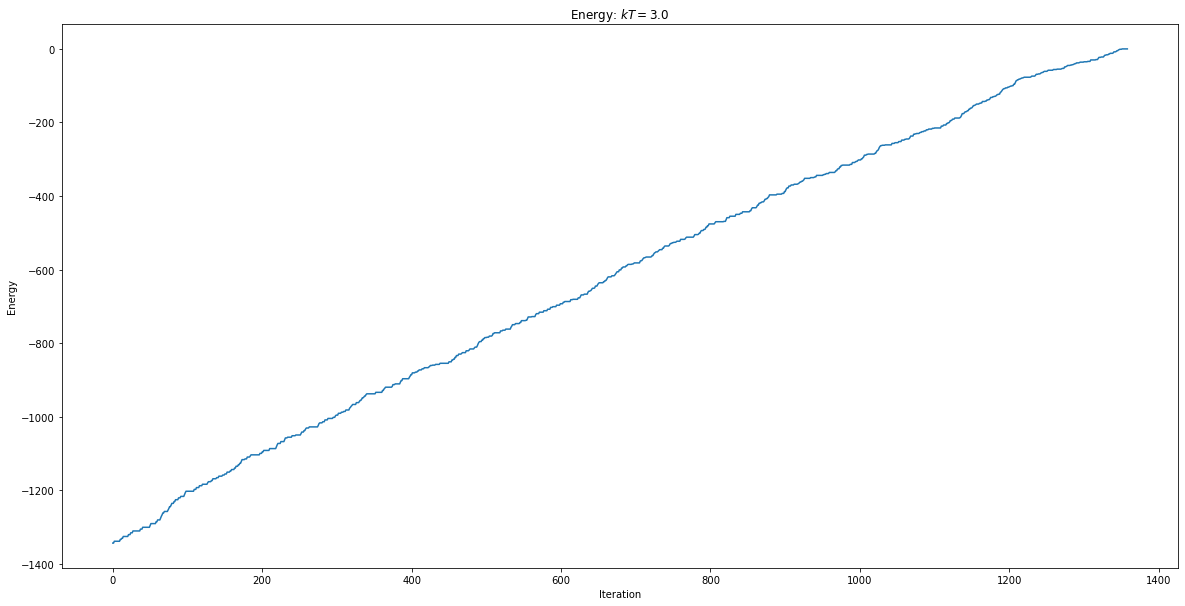

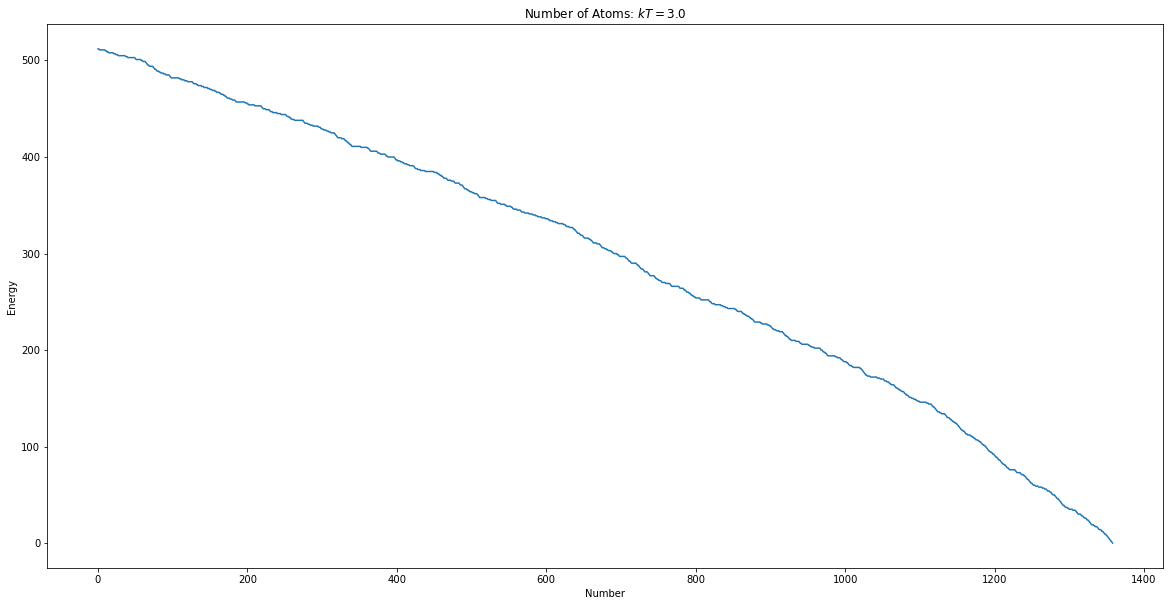

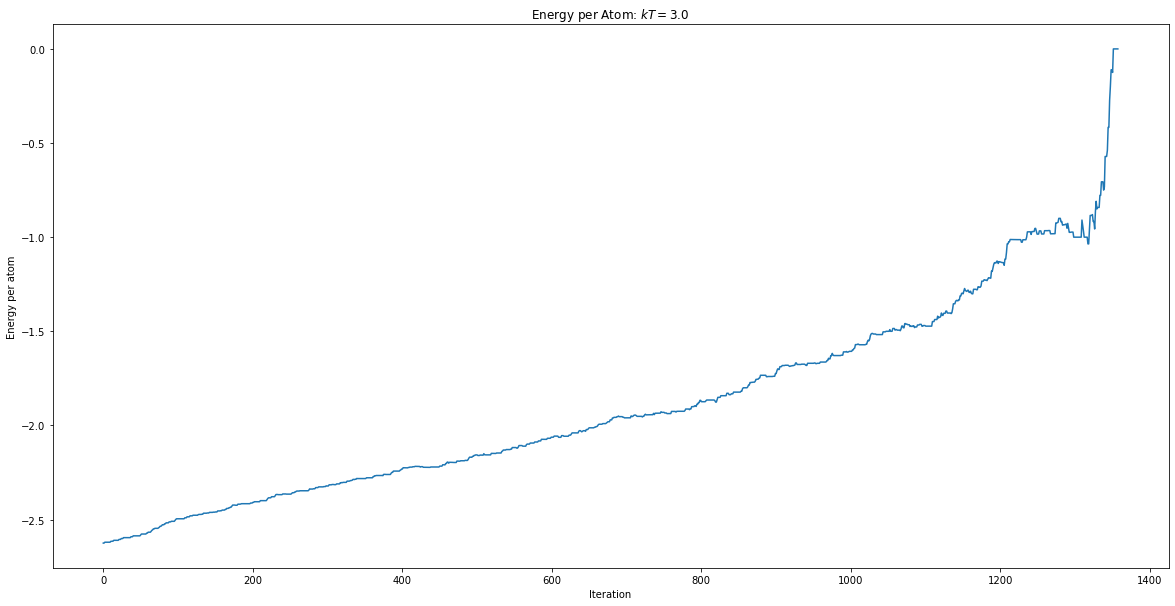

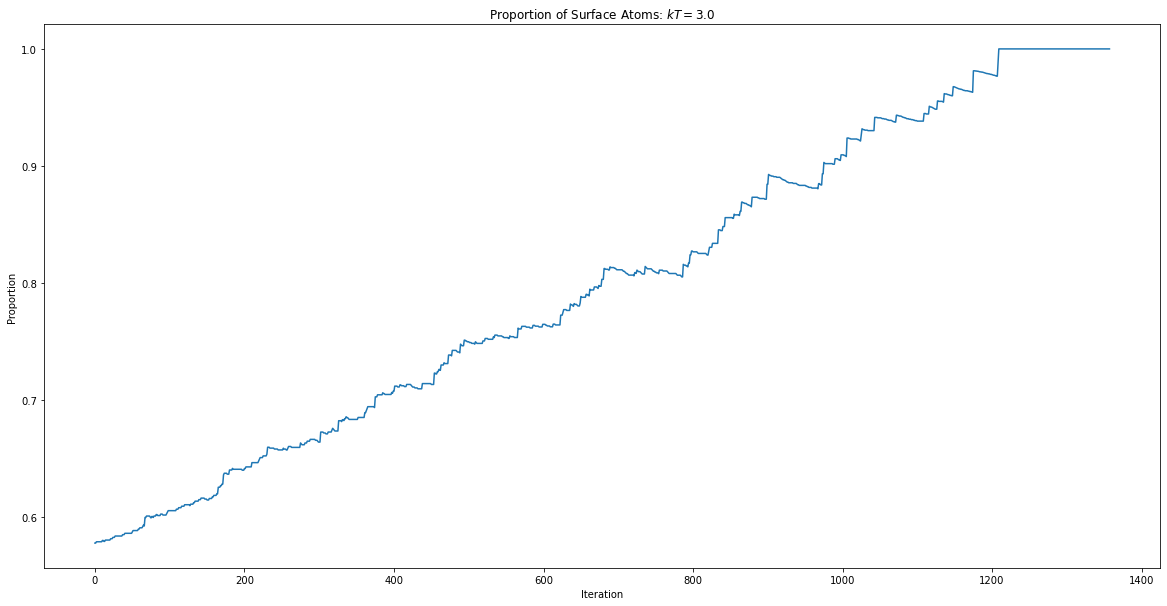

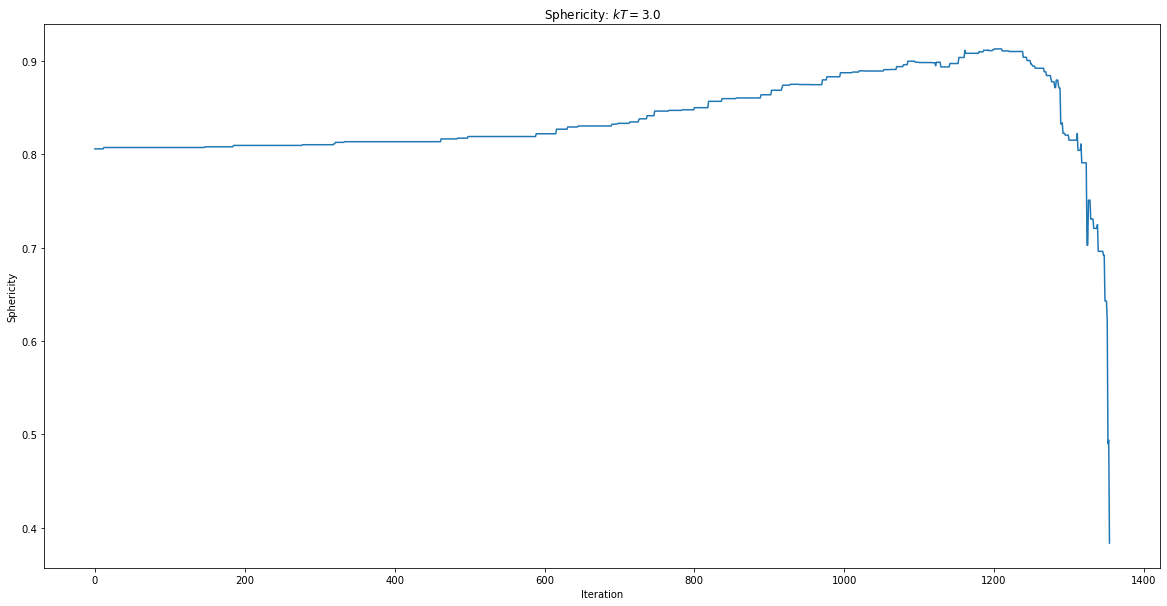

In [8]:
temps = np.arange(0.75,3.25,0.25)
for temp in temps:
    energies, size_atoms, surface_size, sphericity = sublimation_sim(seed=1, kT=temp)

    plt.plot(energies)
    plt.title(f'Energy: $kT={temp}$')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()

    plt.plot(size_atoms)
    plt.title(f'Number of Atoms: $kT={temp}$')
    plt.xlabel('Number')
    plt.ylabel('Energy')
    plt.show()

    plt.plot(energies[:-1]/size_atoms[:-1])
    plt.title(f'Energy per Atom: $kT={temp}$')
    plt.xlabel('Iteration')
    plt.ylabel('Energy per atom')
    plt.show()

    plt.plot(surface_size[:-1]/size_atoms[:-1])
    plt.title(f'Proportion of Surface Atoms: $kT={temp}$')
    plt.xlabel('Iteration')
    plt.ylabel('Proportion')
    plt.show()

    plt.plot(sphericity)
    plt.title(f'Sphericity: $kT={temp}$')
    plt.xlabel('Iteration')
    plt.ylabel('Sphericity')
    plt.savefig(f'Sphericity_{int(100*temp):03d}.jpg', dpi=600, bbox_inches = 'tight')
    plt.show()

## Effects of Different Random Seeds

Mean iterations 14379.170
Deviation 829.819
Min 12646
Max 16681
Deviation 5.77
Min 12.05
Max 16.01


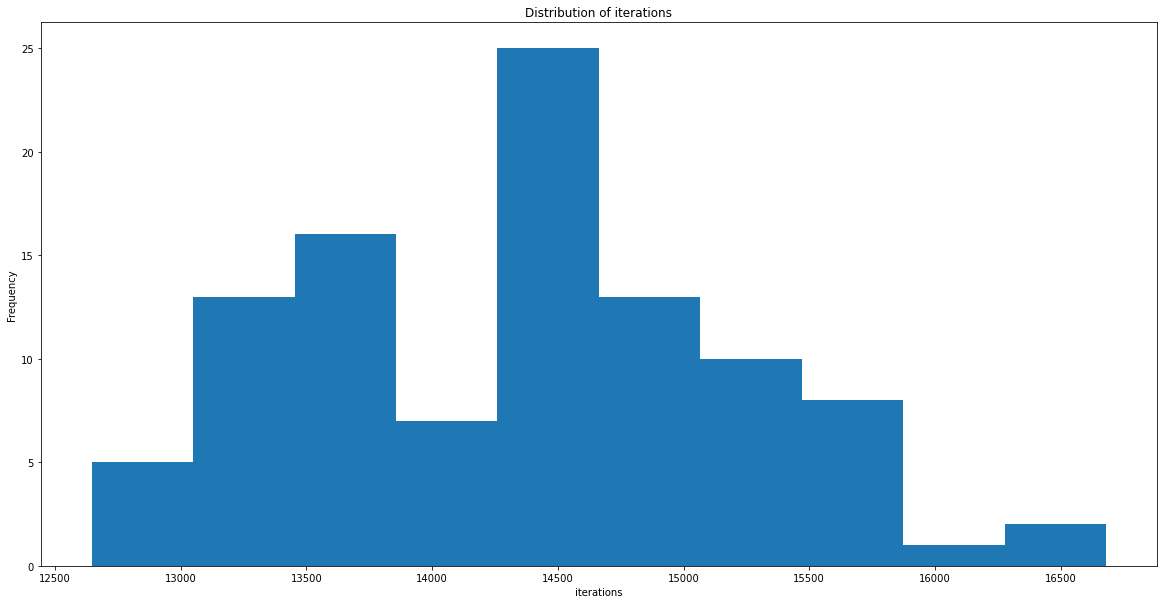

In [15]:
seeds = np.arange(0,100,1)
iterations = []
for seed in seeds:
    energies, size_atoms, surface_size, sphericity = sublimation_sim(seed = seed, kT=1)

    # plt.plot(energies)
    # plt.title(f'Energy: $kT={temp}$')
    # plt.xlabel('Iteration')
    # plt.ylabel('Energy')
    # plt.show()

    # plt.plot(energies[:-1]/size_atoms[:-1])
    # plt.title(f'Energy per Atom: $kT={temp}$')
    # plt.xlabel('Iteration')
    # plt.ylabel('Energy per atom')
    # plt.show()

    # plt.plot(surface_size[:-1]/size_atoms[:-1])
    # plt.title(f'Proportion of Surface Atoms: $kT={temp}$')
    # plt.xlabel('Iteration')
    # plt.ylabel('Proportion')
    # plt.show()

    # plt.plot(sphericity)
    # plt.title(f'Sphericity: $seed={seed}$')
    # plt.xlabel('Iteration')
    # plt.ylabel('Sphericity')
    # plt.show()
    iterations.append(len(sphericity))
iterations=np.array(iterations)
print(f'Mean iterations {np.mean(iterations):.03f}')
print(f'Deviation {np.std(iterations):.03f}')
print(f'Min {np.min(iterations)}')
print(f'Max {np.max(iterations)}')
print(f'Deviation {100*np.std(iterations)/np.mean(iterations):.02f}')
print(f'Min {100*(1-np.min(iterations)/np.mean(iterations)):.02f}')
print(f'Max {100*(np.max(iterations)/np.mean(iterations) -1):.02f}')
plt.hist(iterations)
plt.xlabel('iterations')
plt.ylabel('Frequency')
plt.title('Distribution of iterations')
plt.show()